In [ ]:
#import all features
!pip install yfinance
!pip install ta

import yfinance as yf
import pandas as pd
import numpy as np
import math
import random
from ta import add_all_ta_features
from ta.utils import dropna
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
import matplotlib.pyplot as plt


#Creating MACD Strategy:
We are using settings of (26,12,9)

The rule that we will be following would be:
-> MACD crosses ABOVE signal line = Buy Position
-> MACD crosses BELOW signal line = Sell Position


In [ ]:
stock_list = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]
start = "2015-01-01"
end = "2019-12-31"

In [ ]:
# Define a function for MACD-based backtesting
def custom_MACD_backtest(stock_symbol, setting=(26,12,9), start_date="2015-01-01", end_date="2019-12-31"):
    # Fetch historical stock price data for the specified stock symbol and time period
    stock_data = yf.Ticker(stock_symbol)
    historical_data = stock_data.history(start=start_date, end=end_date)

    slow_ema_period = setting[0]
    fast_ema_period = setting[1]
    signal_period = setting[2]
    # Calculate MACD indicators
    macd_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd()
    signal_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_signal()
    histogram = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_diff()

    # Create a DataFrame to store backtesting results
    backtest_df = pd.DataFrame()
    backtest_df["Close"] = historical_data["Close"]
    backtest_df["MACD_Line"] = macd_line
    backtest_df["Signal_Line"] = signal_line
    backtest_df["Histogram"] = histogram

    # Handle missing values resulting from moving averages calculations
    # backtest_df = backtest_df.dropna()

    # Generate trading positions based on MACD signals: 1 for Long, -1 for Short
    backtest_df["Position"] = np.where(backtest_df['MACD_Line'] > backtest_df['Signal_Line'], 1.0, -1.0)

    # Calculate trading signals: difference in positions
    backtest_df["Signal"] = backtest_df['Position'].diff()

    # Compute daily stock returns and strategy returns
    backtest_df['Stock Log Returns'] = np.log(backtest_df["Close"] / backtest_df["Close"].shift(1))
    backtest_df["Strategy Log Returns"] = backtest_df["Stock Log Returns"] * backtest_df["Position"].shift(1)
    backtest_df["Stock Returns"] = (backtest_df["Close"] - backtest_df["Close"].shift(1)) / backtest_df["Close"].shift(1)
    backtest_df["Strategy Returns"] = backtest_df["Stock Returns"] * backtest_df["Position"].shift(1)

    return backtest_df



In [ ]:
MAANG_df_list_MACD = []
stock_list = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]
for stock in stock_list:
  MAANG_df_list_MACD.append(custom_MACD_backtest(stock))

# Zipping the data
stock_list = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]
stock_name_and_df = list(zip(stock_list, MAANG_df_list_MACD))

Plot Long/Short status for the stocks

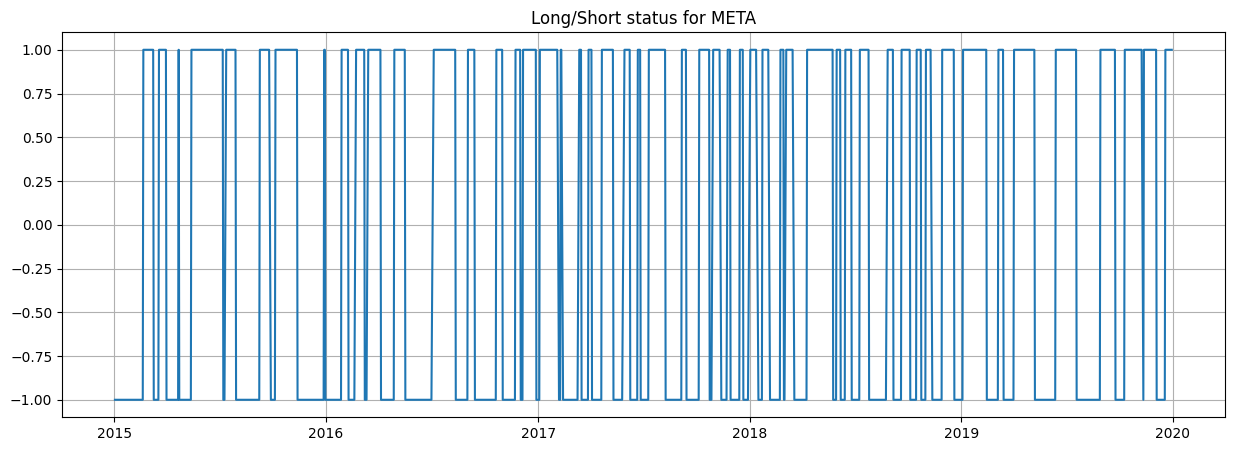

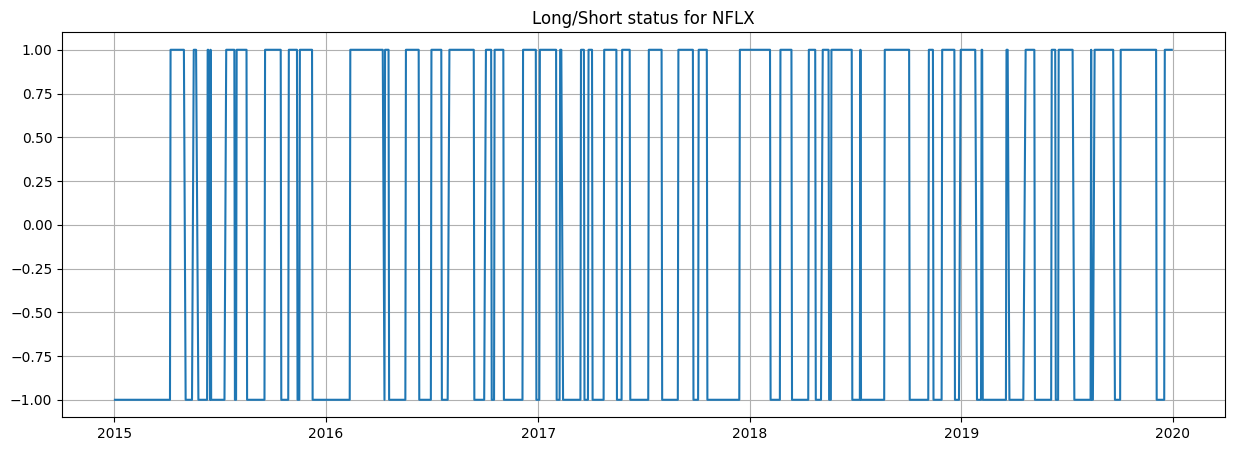

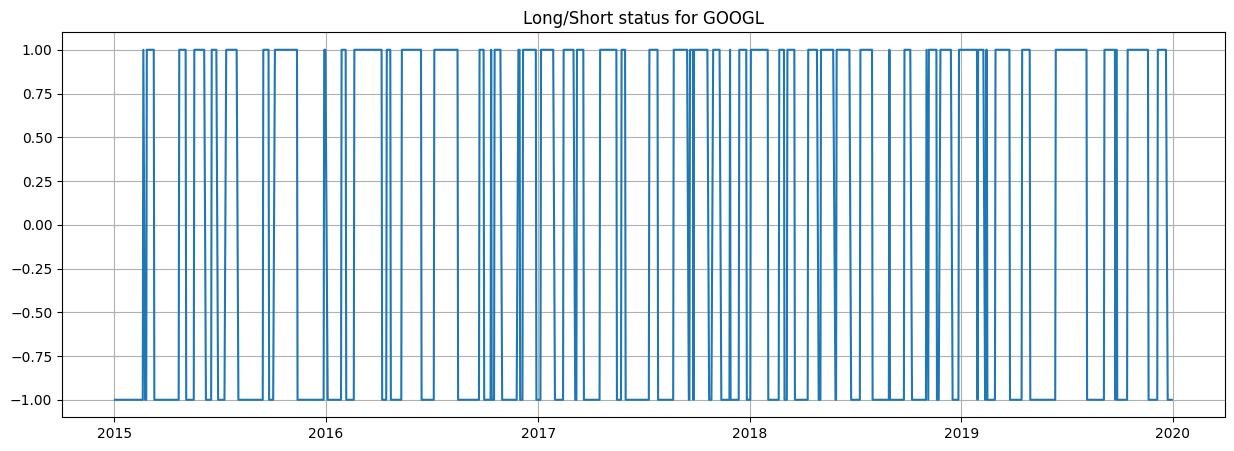

In [ ]:
# Plotting Long/Short Status for the stocks
for stock_name, s  in stock_name_and_df:
  plt.figure(figsize=(15,5))
  plt.plot(s["Position"])
  plt.title(f"Long/Short status for {stock_name}")
  plt.grid()
  plt.show()

Plot line chart of Stock and Strategy Log Returns

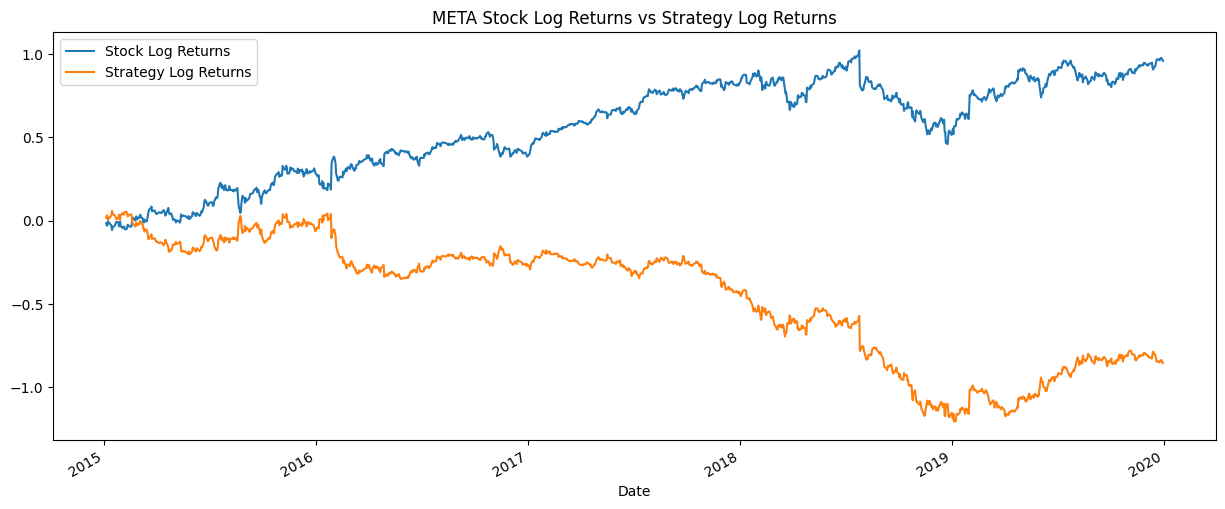

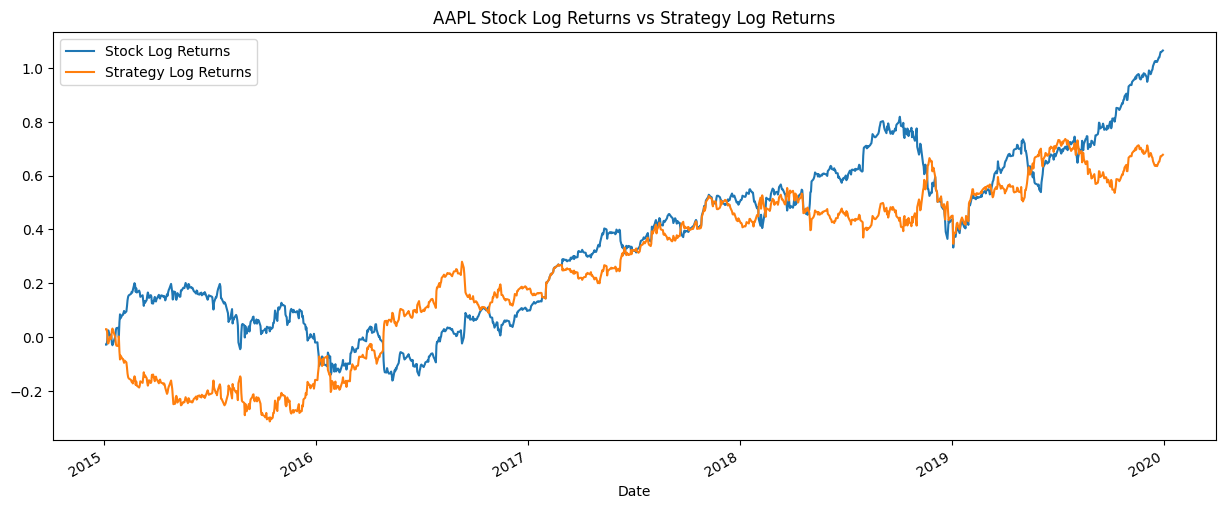

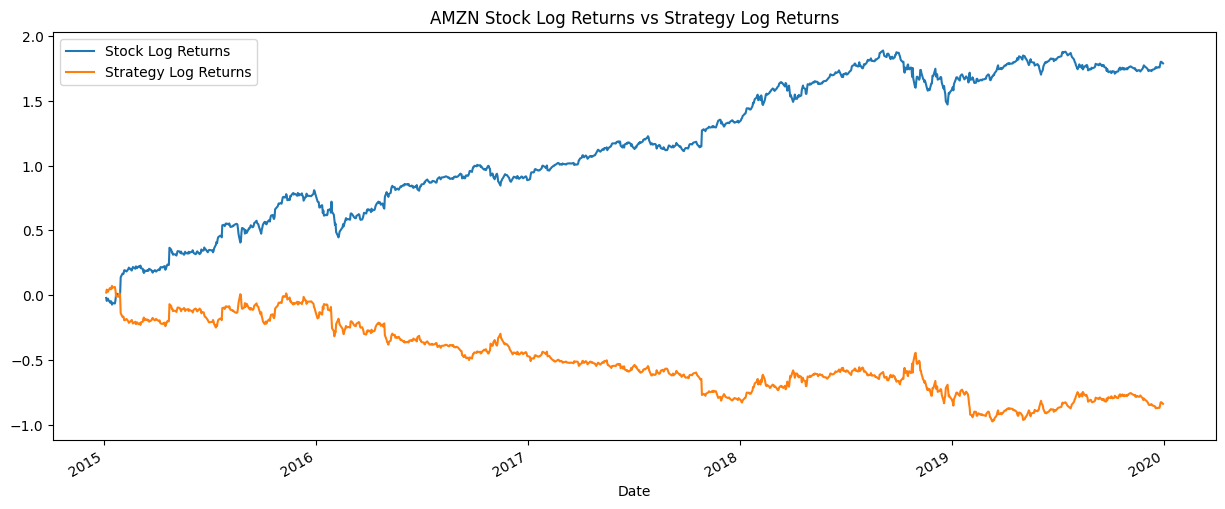

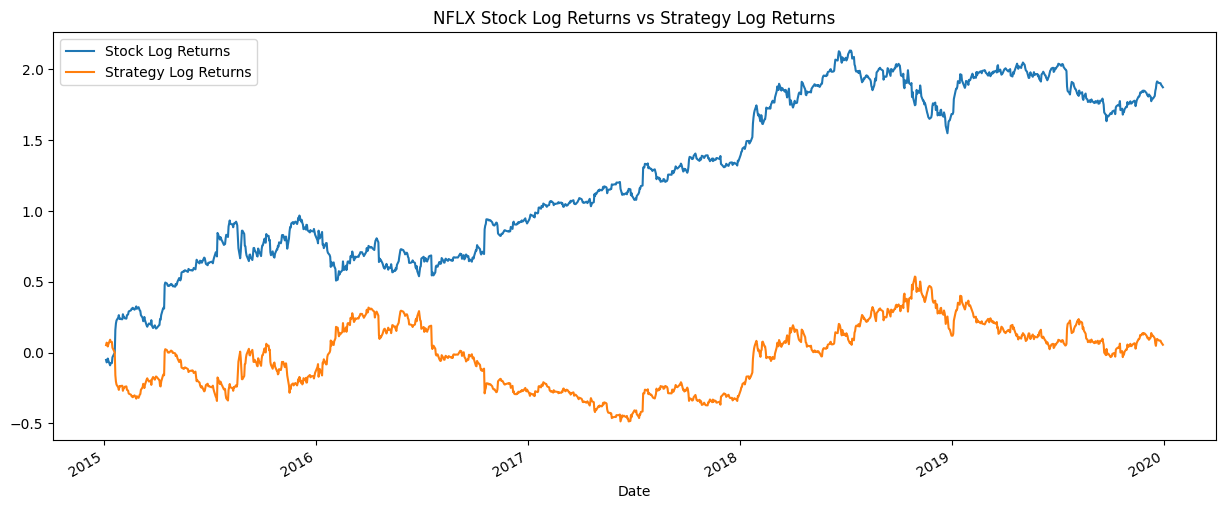

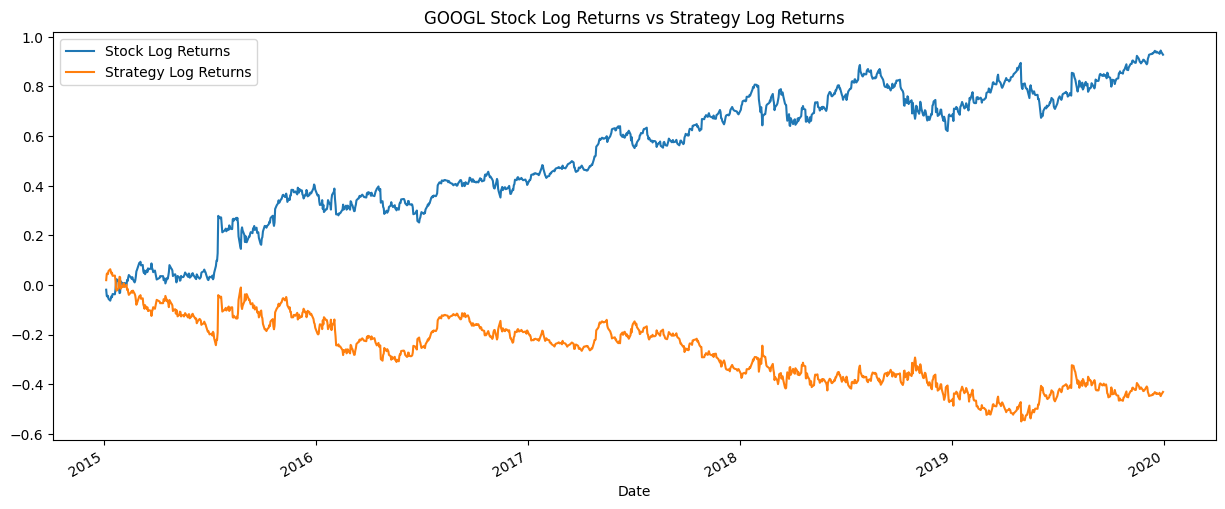

In [ ]:
# Plotting the Stock Log Returns vs Strategy Log Returns
for stock_name, df in stock_name_and_df:
  df[["Stock Log Returns", "Strategy Log Returns"]].cumsum().plot(figsize=(15,6), title = f"{stock_name} Stock Log Returns vs Strategy Log Returns")

Plot the Histogram of Daily Stock vs Strategy Returns

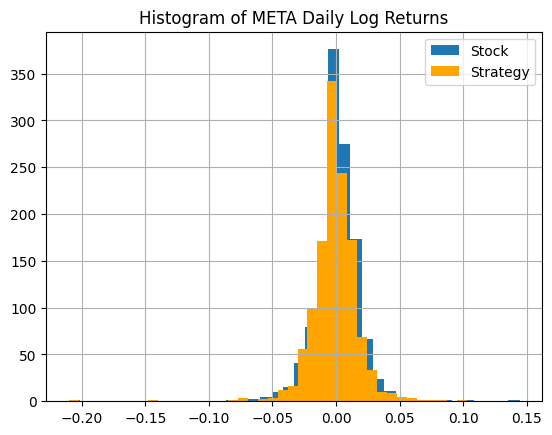

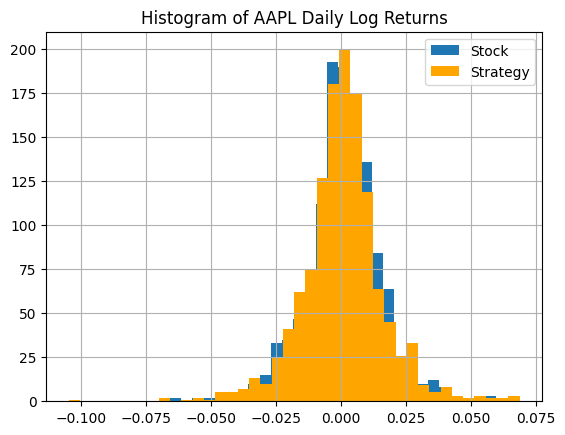

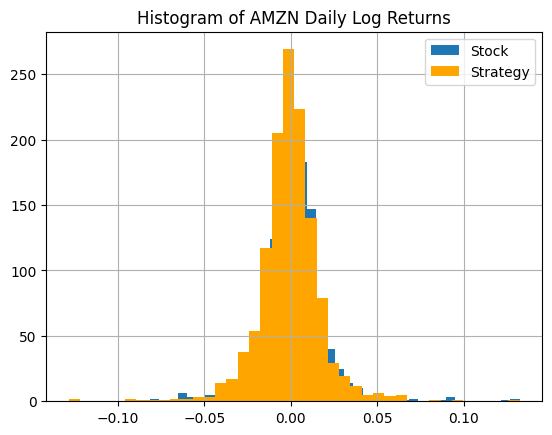

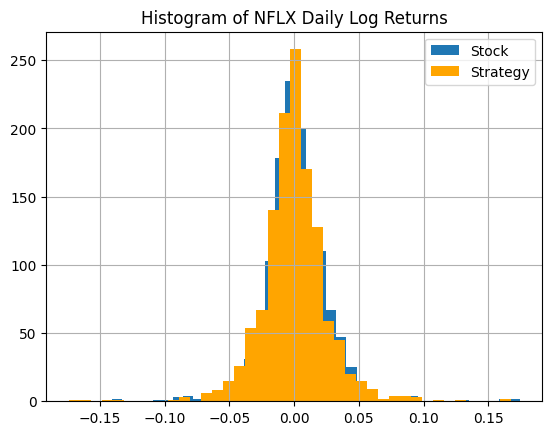

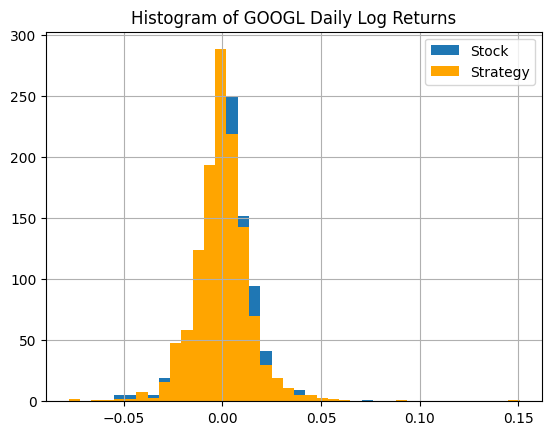

In [ ]:
# Create a 3x2 grid of subplots
for stock_name, df in stock_name_and_df:
  plt.hist(df["Stock Log Returns"], bins = 40)
  plt.hist(df["Strategy Log Returns"], bins = 40, color = "Orange")
  plt.title(f"Histogram of {stock_name} Daily Log Returns")
  plt.legend(['Stock', 'Strategy'])
  plt.grid()
  plt.show()

Plot MACD and Signal Line

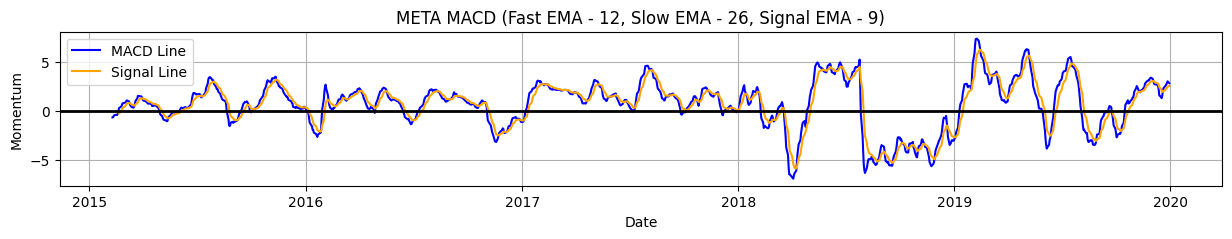

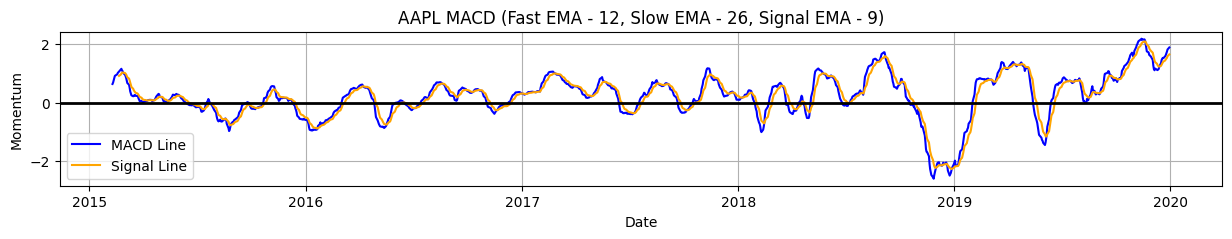

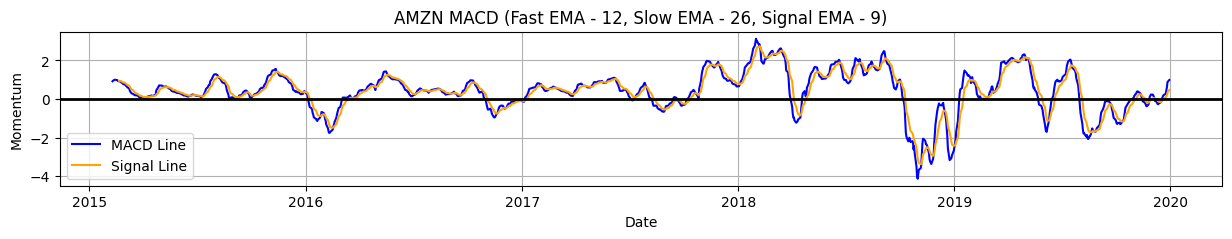

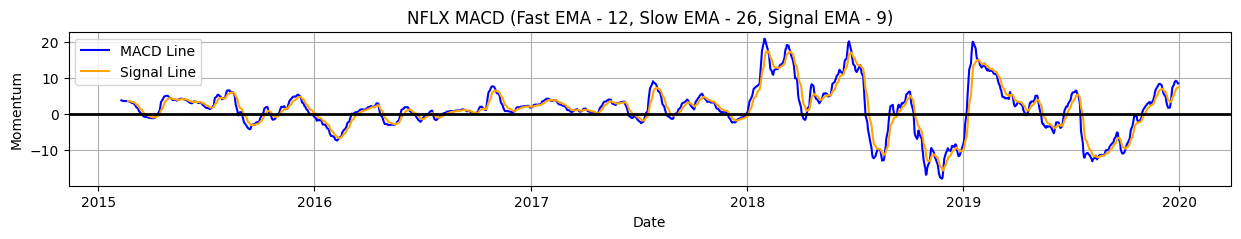

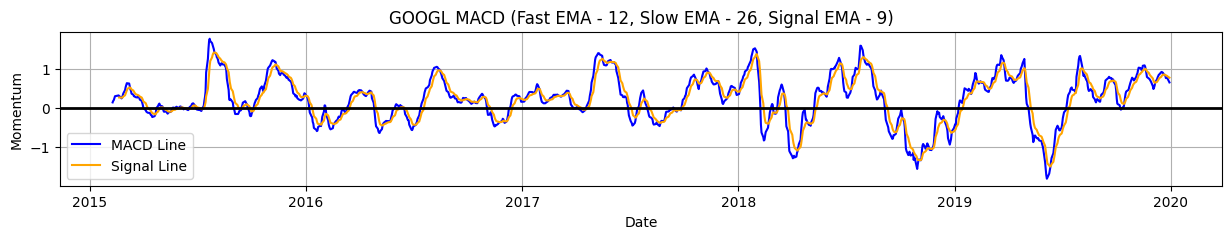

In [ ]:
# MACD Plot
for stock_name, s  in stock_name_and_df:
  slow_ema_period = 26
  fast_ema_period = 12
  signal_period = 9


  plt.figure(figsize=(15, 2))
  plt.plot(s["MACD_Line"], color='blue', label='MACD Line')
  plt.plot(s["Signal_Line"], color='orange', label='Signal Line')
  plt.axhline(y=0,color='black', linestyle='-', linewidth=2)
  plt.xlabel("Date")
  plt.ylabel("Momentum")
  plt.title("{} MACD (Fast EMA - {}, Slow EMA - {}, Signal EMA - {})".format(stock_name, fast_ema_period, slow_ema_period, signal_period))
  plt.legend()
  plt.grid()
  plt.show()

Calculating the Performance Metrics

In [ ]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

To convert log returns to regular returns:
Regular returns  = Exp(Log returns) - 1
Log Returns  = Ln(1 + Regular returns)

'''
benchmark_symbol = "^GSPC"
for stock_name, df in stock_name_and_df:
  # 1.  Annual Mean Returns or Expected returns
  daily_ret = df[["Stock Log Returns", "Strategy Log Returns"]].mean()
  annual_ret =  daily_ret * 252
  #print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

  # Convert back to regular returns
  # Due to the statistical challenges, we cannot perform calculations on gross returns,
  # Hence, we do that in log returns, and then convert back to regular

  annual_regular_ret = np.exp(annual_ret)-1
  print(f'Annual {stock_name} regular returns are: \n',annual_regular_ret)

  #2. Annual Standard deviation
  daily_std = df[["Stock Log Returns", "Strategy Log Returns"]].std()
  annual_std =  daily_std * (252 **0.5)
  #print(f'Annual log std is: \n', annual_std) # Note that these are the log returns

  #Convert to regular
  daily_regular_std = (np.exp(df[["Stock Log Returns", "Strategy Log Returns"]])-1).std()
  annual_regular_std =  daily_regular_std * (252 **0.5)
  print(f'Annual regular {stock_name} standard deviation is: \n', annual_regular_std) # Note that these are the log returns

  #3. Sharpe Ratio
  # Since we have already calculated the annual returns and risk we can use them

  sr = annual_regular_ret/ annual_regular_std
  print(f" The {stock_name} Sharpe Ratio is : \n ", sr, "\n\n")

Annual META regular returns are: 
 Stock Log Returns       0.211844
Strategy Log Returns   -0.157611
dtype: float64
Annual regular META standard deviation is: 
 Stock Log Returns       0.282297
Strategy Log Returns    0.280681
dtype: float64
 The META Sharpe Ratio is : 
  Stock Log Returns       0.750429
Strategy Log Returns   -0.561532
dtype: float64 


Annual AAPL regular returns are: 
 Stock Log Returns       0.238325
Strategy Log Returns    0.145633
dtype: float64
Annual regular AAPL standard deviation is: 
 Stock Log Returns       0.248457
Strategy Log Returns    0.249058
dtype: float64
 The AAPL Sharpe Ratio is : 
  Stock Log Returns       0.959222
Strategy Log Returns    0.584735
dtype: float64 


Annual AMZN regular returns are: 
 Stock Log Returns       0.431946
Strategy Log Returns   -0.154741
dtype: float64
Annual regular AMZN standard deviation is: 
 Stock Log Returns       0.292617
Strategy Log Returns    0.290108
dtype: float64
 The AMZN Sharpe Ratio is : 
  Stock Log Ret

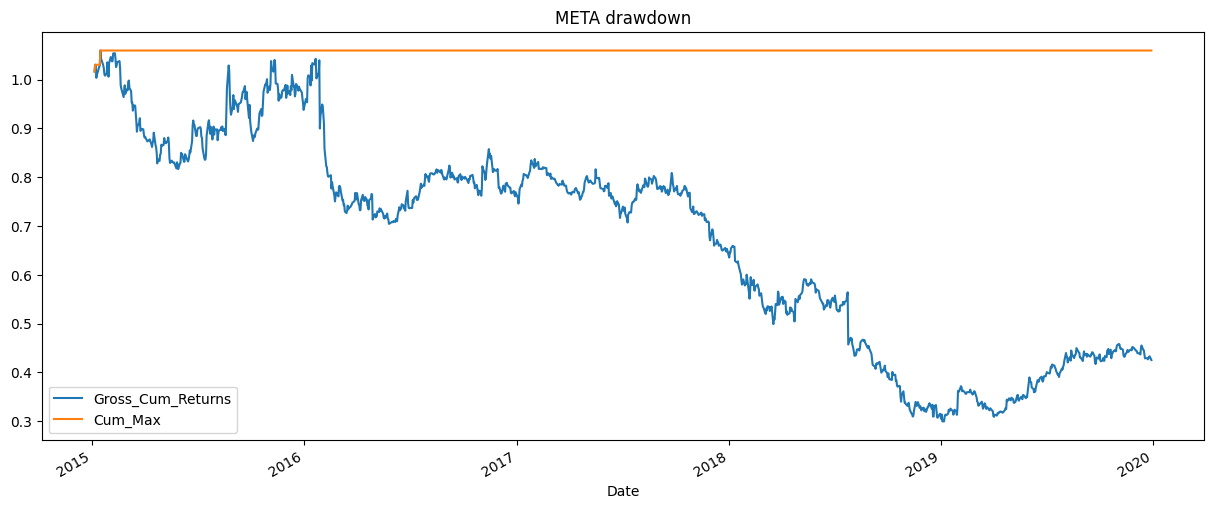

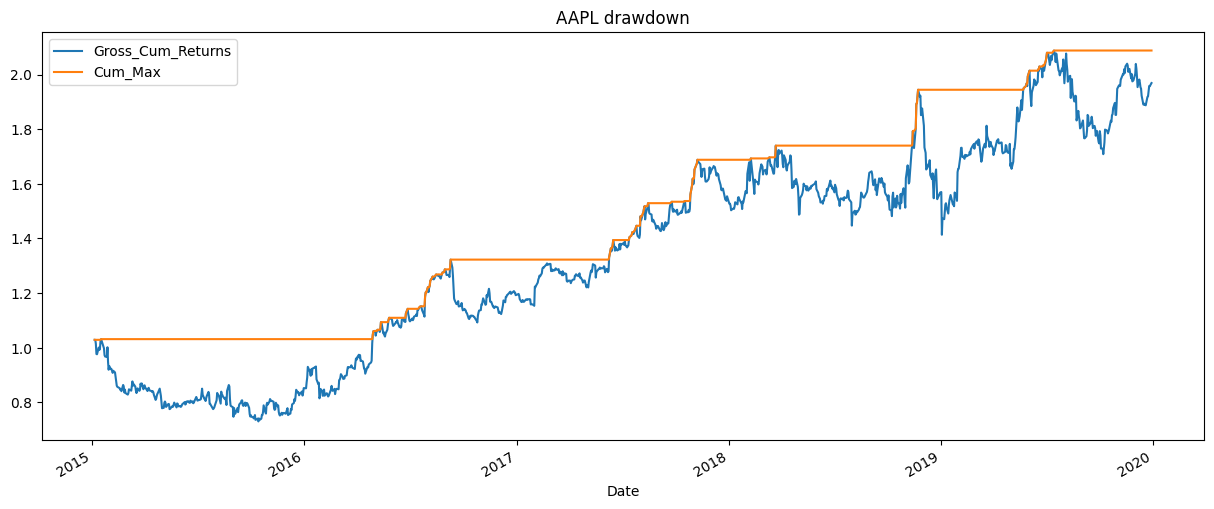

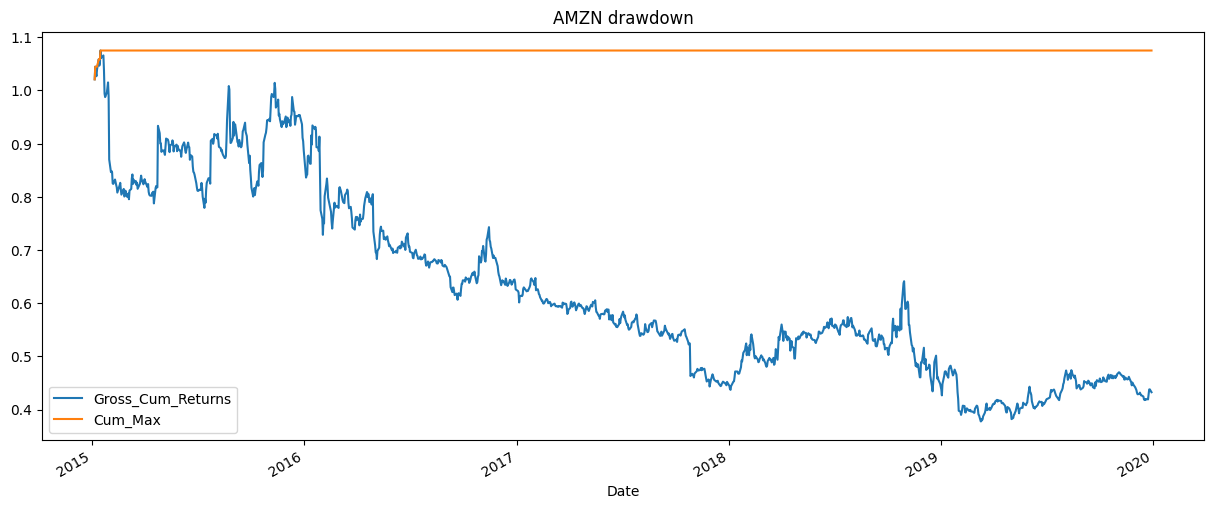

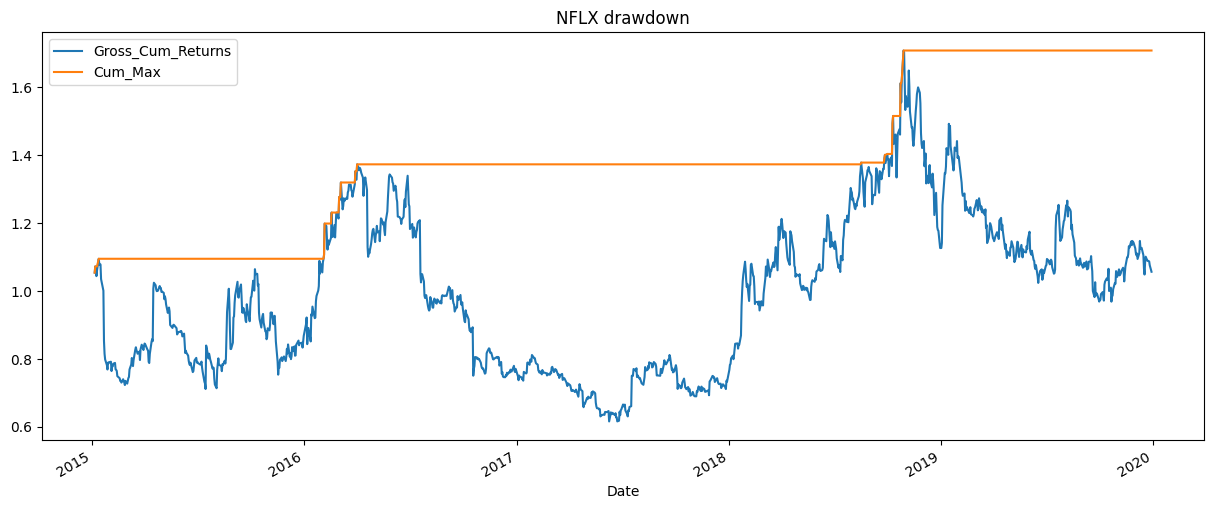

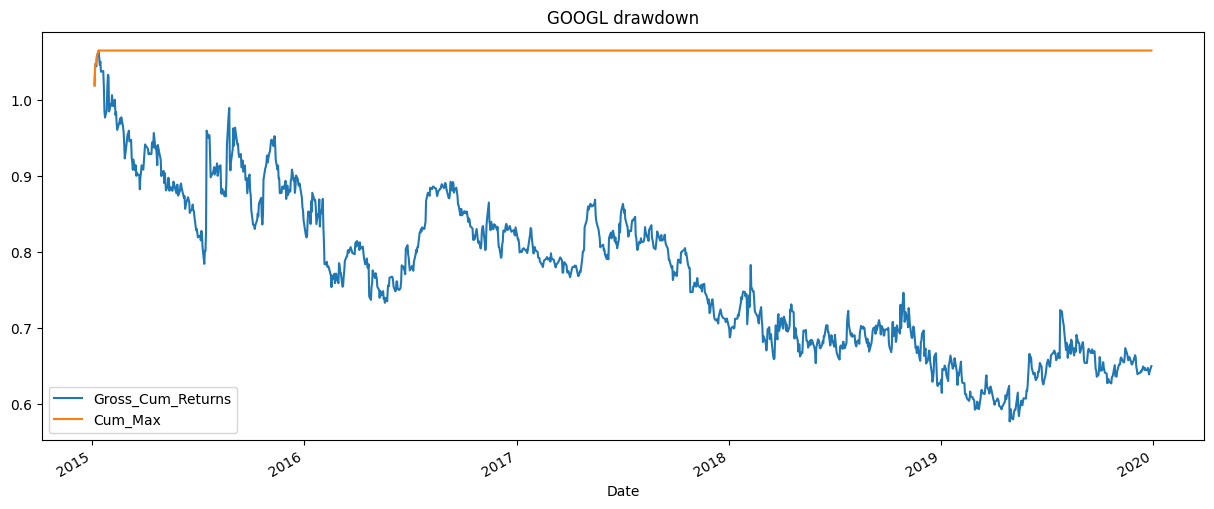

In [ ]:
for stock_name, df in stock_name_and_df:
  df["Gross_Cum_Returns"] = df["Strategy Log Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
  df["Cum_Max"] = df["Gross_Cum_Returns"].cummax()
  df[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6), title = f"{stock_name} drawdown")

  drawdown = df["Cum_Max"] - df["Gross_Cum_Returns"] # it gives the difference between orange and blue

  df["drawdown"] = drawdown

  # The maximum difference is refered as "Drawdown"

  max_drawdown = df["drawdown"].max()


  # Although we know the max drawdown, we dont know how long it happened.
  # Lets calculate tha max drawdown period
  # The idea is to store all the points where the blue and orange meet (i.e. gross vs maximum)
  # and then calculate the difference between these points. The highest difference is the longest drawdown period.

  zero_periods = drawdown[drawdown == 0]

  zero_periods

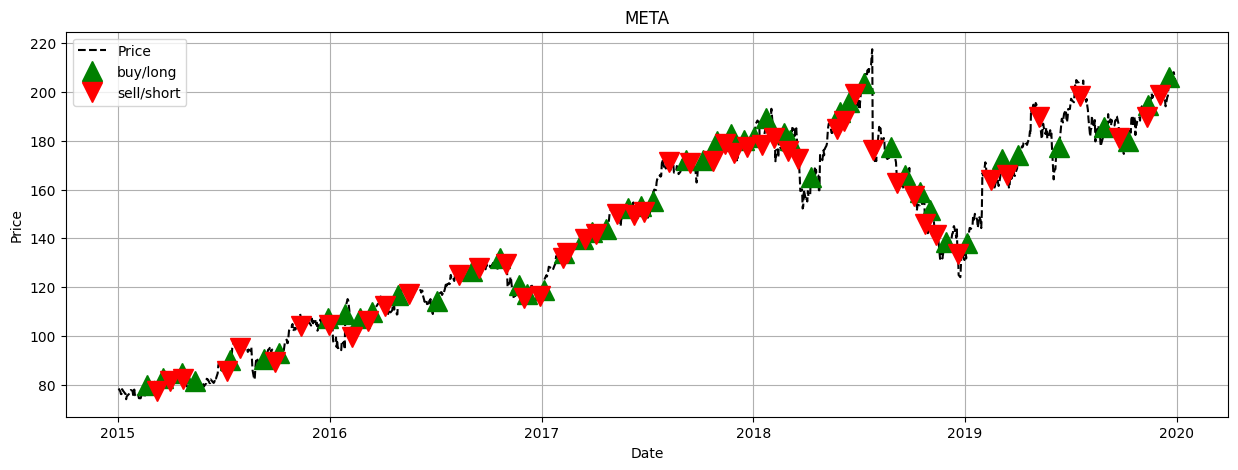

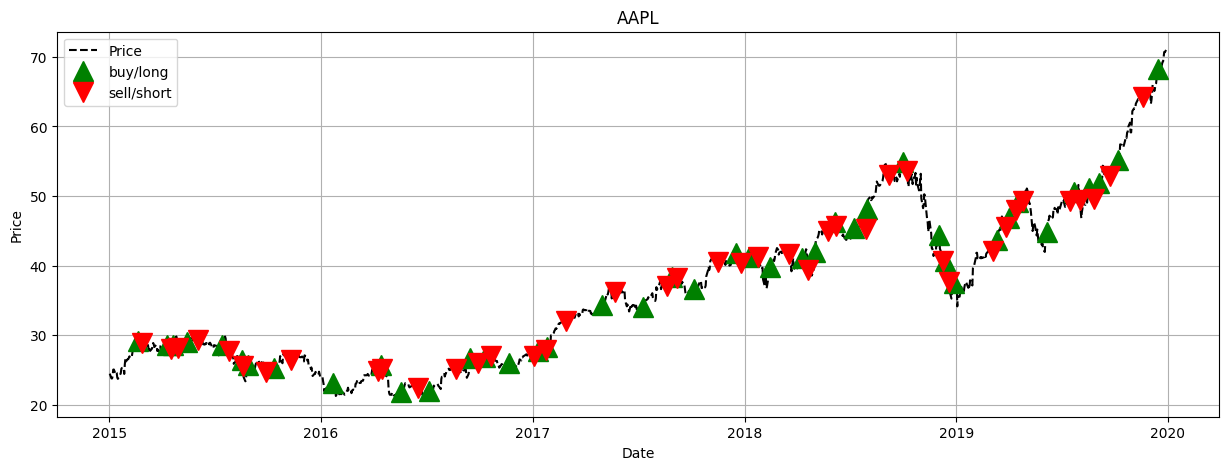

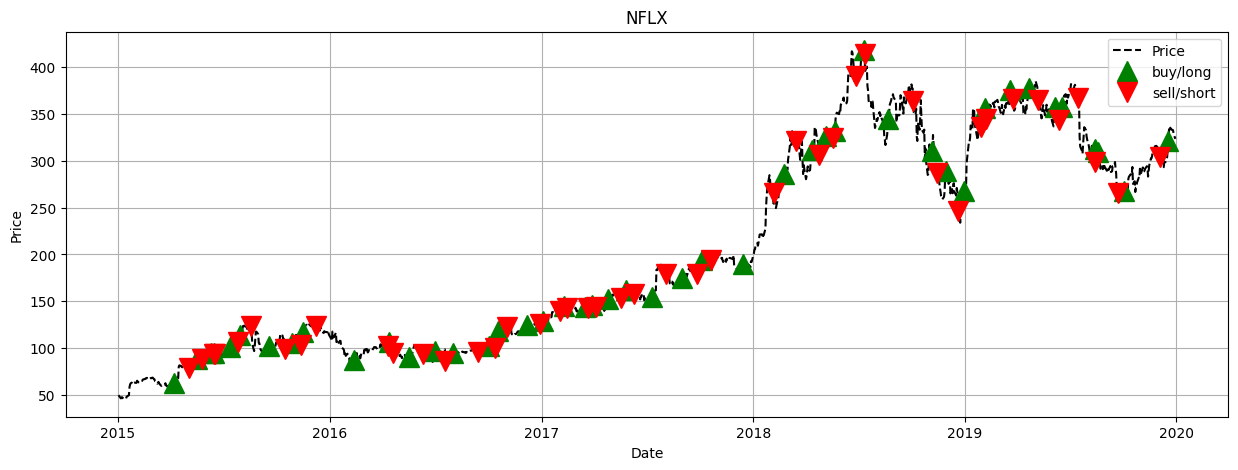

In [ ]:
for stock_name, df in stock_name_and_df:
    plt.figure(figsize=(15, 5))
    plt.plot(df["Close"] ,color='black', label='Price', linestyle='dashed')
    plt.plot(df[df['Signal'] == 2].index,  # plot ‘BUY crossover ’ signals
            df['Close'][df['Signal'] == 2],
            '^', markersize = 15, color = 'g', label = 'buy/long')
    plt.plot(df[df['Signal'] == -2].index,  # plot ‘SELL crossover ’ signals
            df['Close'][df['Signal'] == -2],
            'v', markersize = 15, color = 'r', label = 'sell/short')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("{}".format(stock_name))
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
 #finding weighted portfolio returns
meta_macd = stock_name_and_df[0][1]
aapl_macd = stock_name_and_df[1][1]
amzn_macd = stock_name_and_df[2][1]
nflx_macd = stock_name_and_df[3][1]
googl_macd = stock_name_and_df[4][1]

MACD_portfolio_returns= (meta_macd["Strategy Returns"] + aapl_macd["Strategy Returns"] + amzn_macd["Strategy Returns"] + nflx_macd["Strategy Returns"] + googl_macd["Strategy Returns"]) / 5
# R = log (R +1)
MACD_portfolio_returns.apply(np.log1p).sum()

-0.38661826966174534

In [ ]:
MACD_portfolio_returns.apply(np.log1p).cumsum().plot(figsize=(15,6), title = f"Portfolio Returns (MACD)")

<Axes: title={'center': 'Portfolio Returns (MACD)'}, xlabel='Date'>

# Variation 2: MACD + RSI

In [ ]:
# Define a custom function for MACD-based backtesting
def MACD_RSI_backtest(stock_symbol, setting=(26,12,9), RSI_settings = (70,30), start_date="2015-01-01", end_date="2019-12-31"):
    # Fetch historical stock price data for the specified stock symbol and time period
    stock_data = yf.Ticker(stock_symbol)
    historical_data = stock_data.history(start=start_date, end=end_date)

    slow_ema_period = setting[0]
    fast_ema_period = setting[1]
    signal_period = setting[2]

    # Calculate MACD indicators
    macd_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd()
    signal_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_signal()
    histogram = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_diff()

    # Creating RSI indicator
    rsi_indicator = RSIIndicator(close = historical_data['Close'], window= 14, fillna= False)
    daily_rsi = round(rsi_indicator.rsi(),1)

    # Create a DataFrame to store backtesting results
    backtest_df = pd.DataFrame()
    backtest_df["Close"] = historical_data["Close"]
    backtest_df["MACD_Line"] = macd_line
    backtest_df["Signal_Line"] = signal_line
    backtest_df["Histogram"] = histogram
    backtest_df["RSI"] = daily_rsi

    # Generate trading positions based on MACD signals: 1 for Long, -1 for Short
    upper = RSI_settings[0]
    lower = RSI_settings[1]
    backtest_df["Position"] = np.where((backtest_df['MACD_Line'] < backtest_df['Signal_Line'])&(backtest_df["RSI"] < lower) , 1, 0)
    backtest_df["Position"] = np.where((backtest_df['MACD_Line'] < backtest_df['Signal_Line'])& (backtest_df["RSI"] > upper), -1.0, backtest_df["Position"])

    # Calculate trading signals: difference in positions
    backtest_df["Signal"] = backtest_df['Position'].diff()

    # Compute daily stock returns and strategy returns
    backtest_df['Stock Log Returns'] = np.log(backtest_df["Close"] / backtest_df["Close"].shift(1))
    backtest_df["Strategy Log Returns"] = backtest_df["Stock Log Returns"] * backtest_df["Position"].shift(1)
    backtest_df["Stock Returns"] = (backtest_df["Close"] - backtest_df["Close"].shift(1)) / backtest_df["Close"].shift(1)
    backtest_df["Strategy Returns"] = backtest_df["Stock Returns"] * backtest_df["Position"].shift(1)

    return backtest_df



In [ ]:
MAANG_df_list_MACD_RSI = []
for stock in stock_list:
  MAANG_df_list_MACD_RSI.append(MACD_RSI_backtest(stock))

# Zipping the data
stock_name_and_df_MACD_RSI = list(zip(stock_list, MAANG_df_list_MACD_RSI))

Plot the RSI Chart

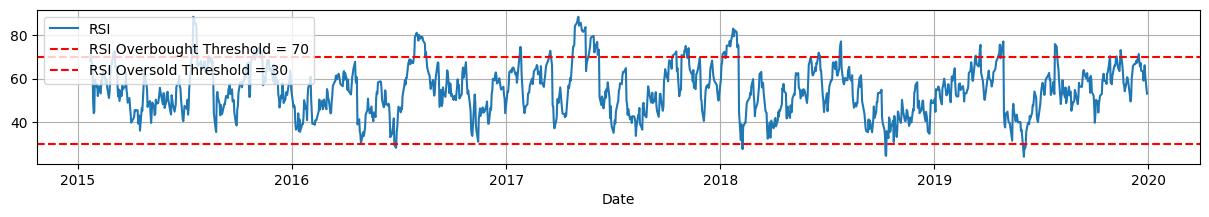

In [ ]:
# RSI plot
for stock_name, s in stock_name_and_df_MACD_RSI:
    plt.figure(figsize=(15, 2))
    plt.plot(s['RSI'], label='RSI')
    plt.axhline(y=70, color='red', label='RSI Overbought Threshold = {}'.format(70), linestyle='dashed')
    plt.axhline(y=30, color='red', label='RSI Oversold Threshold = {}'.format(30), linestyle='dashed')
    plt.xlabel('Date')
    plt.legend()
    plt.grid()
    plt.show()




Plot the Long/Short Status

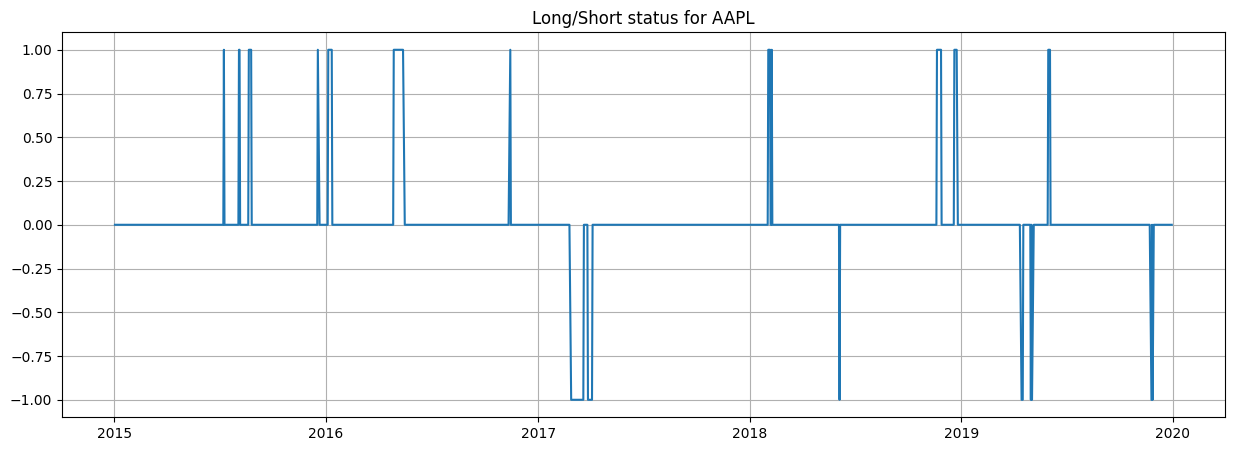

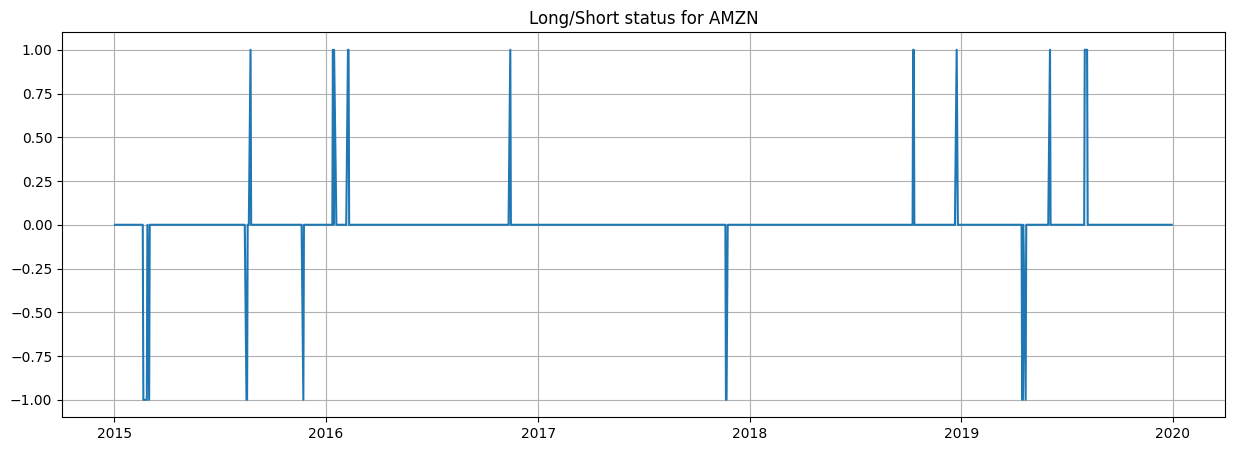

In [ ]:
# Plotting Long/Short Status for the stocks
for stock_name, s  in stock_name_and_df_MACD_RSI:
  plt.figure(figsize=(15,5))
  plt.plot(s["Position"])
  plt.title(f"Long/Short status for {stock_name}")
  plt.grid()
  plt.show()

Plot the Stock Log Returns vs Strategy Log Returns

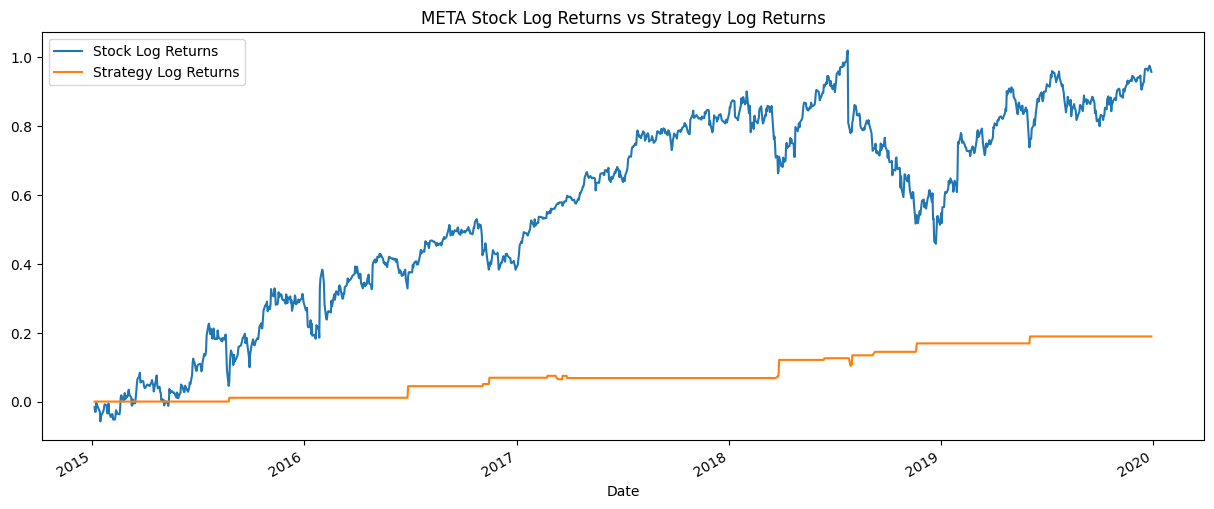

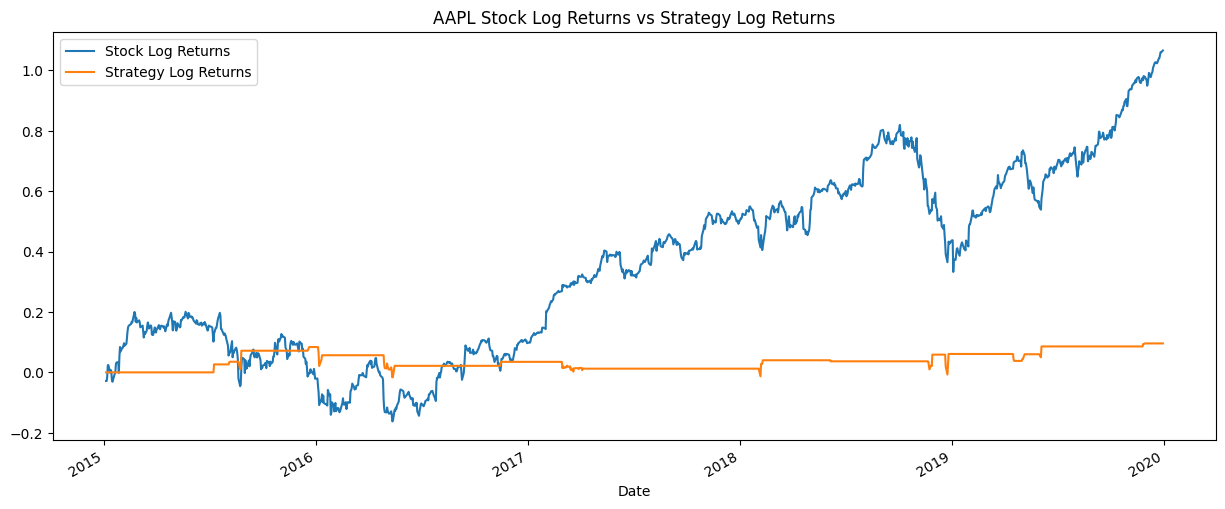

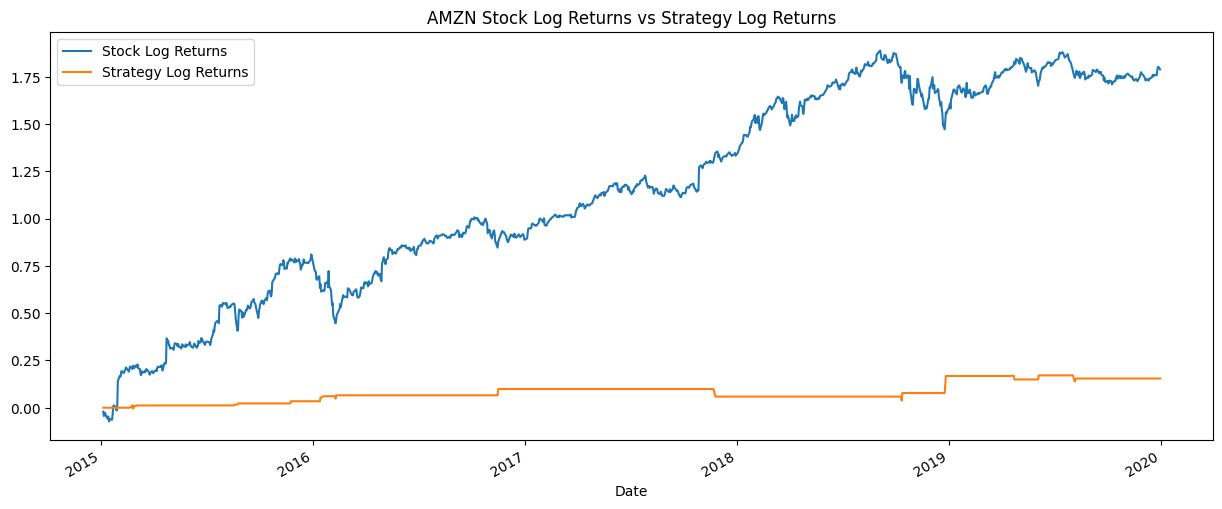

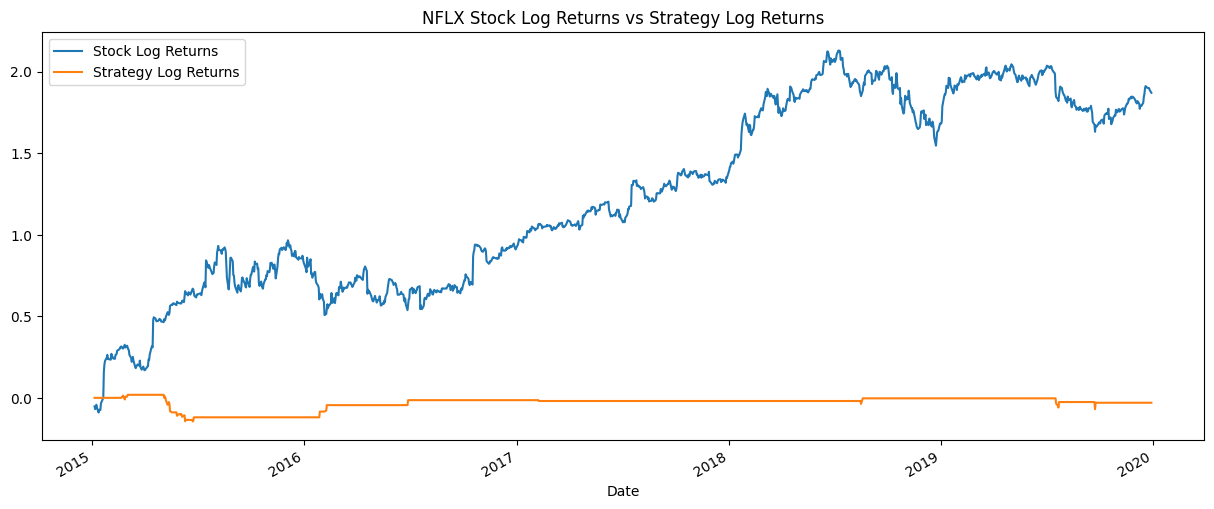

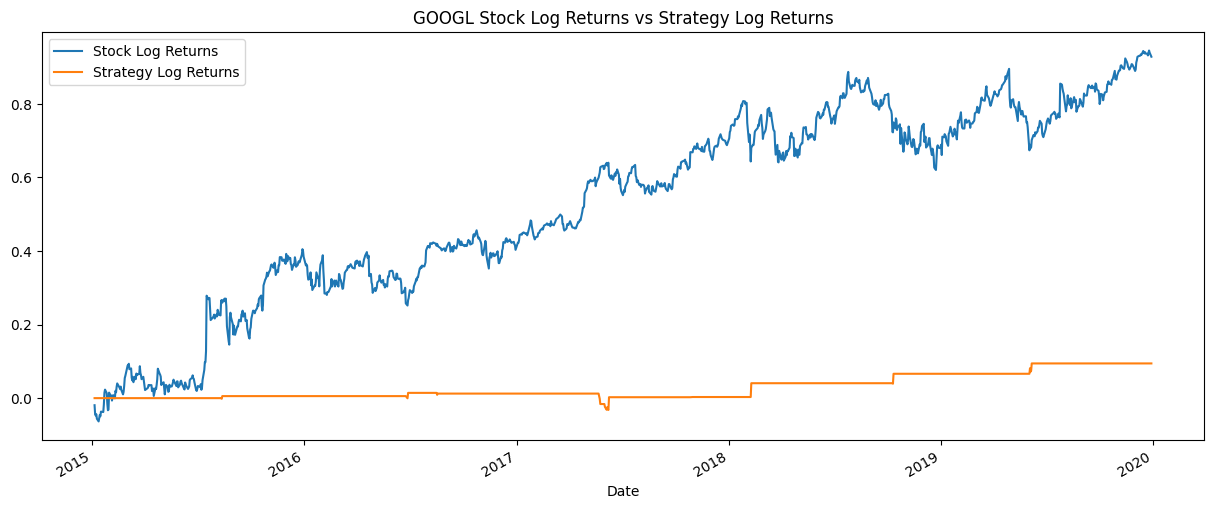

In [ ]:
# Plotting the Stock Log Returns vs Strategy Log Returns
for stock_name, df in stock_name_and_df_MACD_RSI:
  df[["Stock Log Returns", "Strategy Log Returns"]].cumsum().plot(figsize=(15,6), title = f"{stock_name} Stock Log Returns vs Strategy Log Returns")

Plot the Histogram of MAANG vs Strategy Log Returns

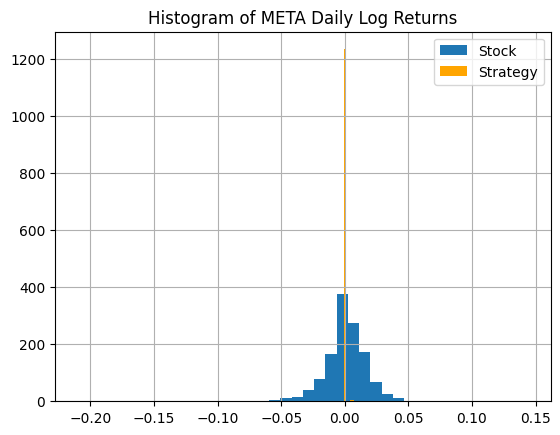

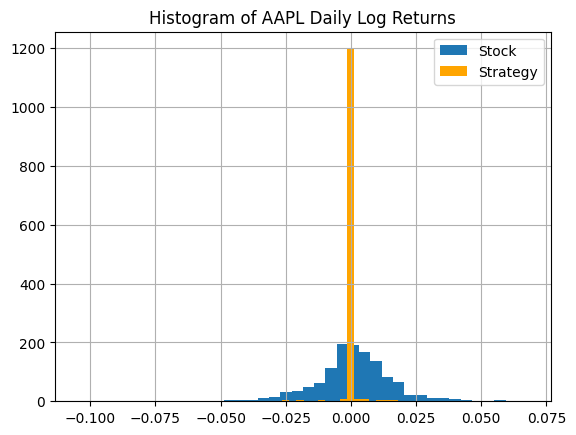

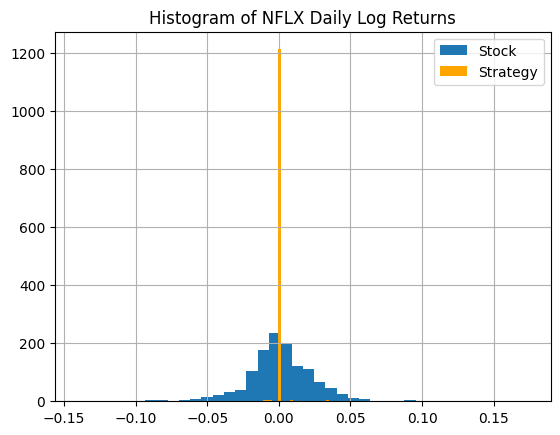

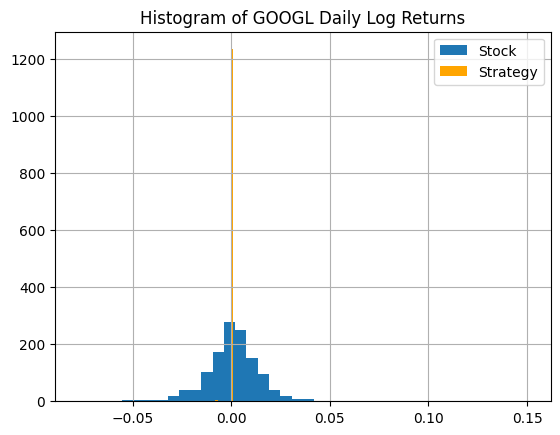

In [ ]:
# Plot Histograms of MAANG vs Strategy Log Returns
for stock_name, df in stock_name_and_df_MACD_RSI:
  plt.hist(df["Stock Log Returns"], bins = 40)
  plt.hist(df["Strategy Log Returns"], bins = 40, color = "Orange")
  plt.title(f"Histogram of {stock_name} Daily Log Returns")
  plt.legend(['Stock', 'Strategy'])
  plt.grid()
  plt.show()

Plot the MACD + RSI chart

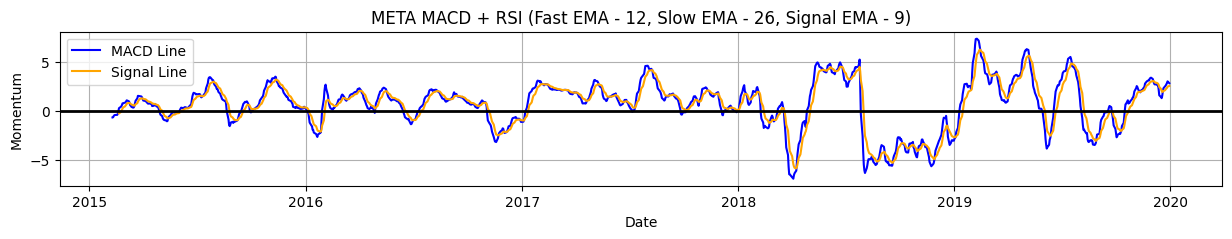

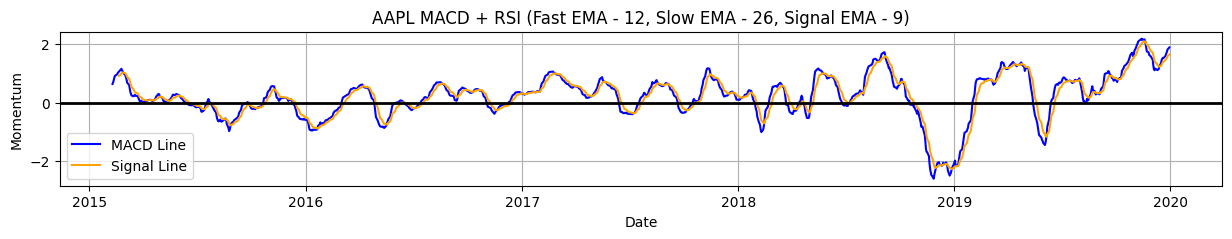

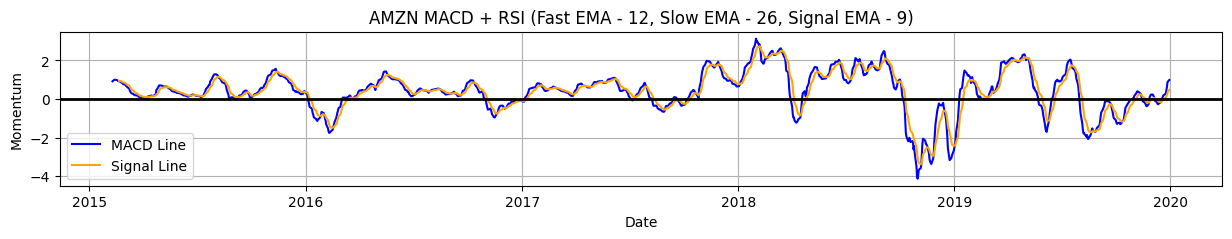

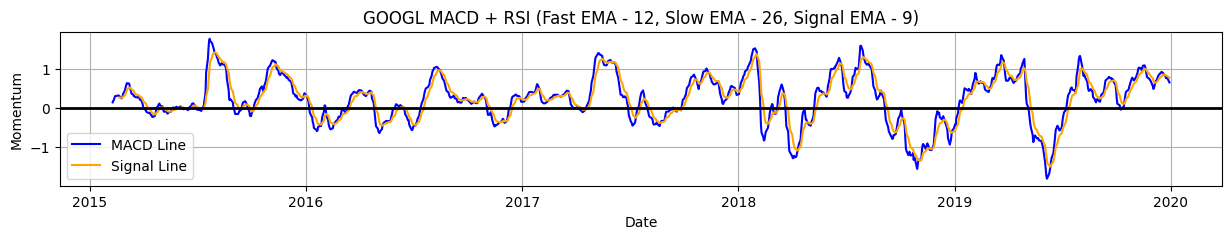

In [ ]:
# MACD Plot
for stock_name, s  in stock_name_and_df_MACD_RSI:
  slow_ema_period = 26
  fast_ema_period = 12
  signal_period = 9


  plt.figure(figsize=(15, 2))
  plt.plot(s["MACD_Line"], color='blue', label='MACD Line')
  plt.plot(s["Signal_Line"], color='orange', label='Signal Line')
  plt.axhline(y=0,color='black', linestyle='-', linewidth=2)
  plt.xlabel("Date")
  plt.ylabel("Momentum")
  plt.title("{} MACD + RSI (Fast EMA - {}, Slow EMA - {}, Signal EMA - {})".format(stock_name, fast_ema_period, slow_ema_period, signal_period))
  plt.legend()
  plt.grid()
  plt.show()

Calculating the Performance Metrics

In [ ]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

To convert log returns to regular returns:
Regular returns  = Exp(Log returns) - 1
Log Returns  = Ln(1 + Regular returns)

'''
benchmark_symbol = "^GSPC"
for stock_name, df in stock_name_and_df_MACD_RSI:
  # 1.  Annual Mean Returns or Expected returns
  daily_ret = df[["Stock Log Returns", "Strategy Log Returns"]].mean()
  annual_ret =  daily_ret * 252
  #print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

  # Convert back to regular returns
  # Due to the statistical challenges, we cannot perform calculations on gross returns,
  # Hence, we do that in log returns, and then convert back to regular

  annual_regular_ret = np.exp(annual_ret)-1
  print(f'Annual {stock_name} regular returns are: \n',annual_regular_ret)

  #2. Annual Standard deviation
  daily_std = df[["Stock Log Returns", "Strategy Log Returns"]].std()
  annual_std =  daily_std * (252 **0.5)
  #print(f'Annual log std is: \n', annual_std) # Note that these are the log returns

  #Convert to regular
  daily_regular_std = (np.exp(df[["Stock Log Returns", "Strategy Log Returns"]])-1).std()
  annual_regular_std =  daily_regular_std * (252 **0.5)
  print(f'Annual regular {stock_name} standard deviation is: \n', annual_regular_std) # Note that these are the log returns

  #3. Sharpe Ratio
  # Since we have already calculated the annual returns and risk we can use them

  sr = annual_regular_ret/ annual_regular_std
  print(f" The {stock_name} Sharpe Ratio is : \n ", sr, "\n\n")

Annual META regular returns are: 
 Stock Log Returns       0.211844
Strategy Log Returns    0.038685
dtype: float64
Annual regular META standard deviation is: 
 Stock Log Returns       0.282297
Strategy Log Returns    0.034944
dtype: float64
 The META Sharpe Ratio is : 
  Stock Log Returns       0.750429
Strategy Log Returns    1.107047
dtype: float64 


Annual AAPL regular returns are: 
 Stock Log Returns       0.238325
Strategy Log Returns    0.019411
dtype: float64
Annual regular AAPL standard deviation is: 
 Stock Log Returns       0.248457
Strategy Log Returns    0.072820
dtype: float64
 The AAPL Sharpe Ratio is : 
  Stock Log Returns       0.959222
Strategy Log Returns    0.266558
dtype: float64 


Annual AMZN regular returns are: 
 Stock Log Returns       0.431946
Strategy Log Returns    0.031477
dtype: float64
Annual regular AMZN standard deviation is: 
 Stock Log Returns       0.292617
Strategy Log Returns    0.057713
dtype: float64
 The AMZN Sharpe Ratio is : 
  Stock Log Ret

Plot the Drawdown chart

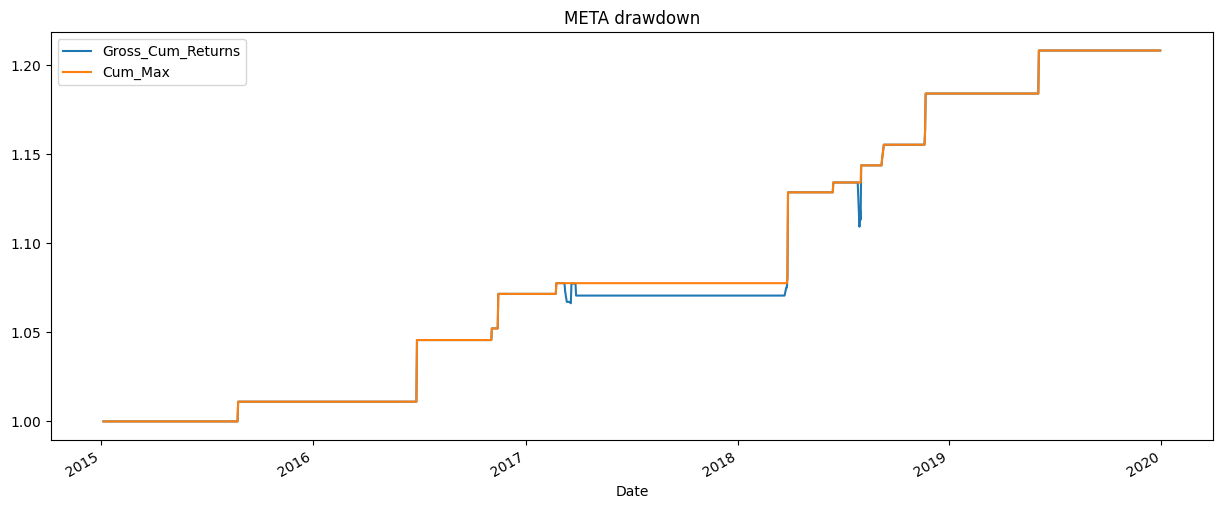

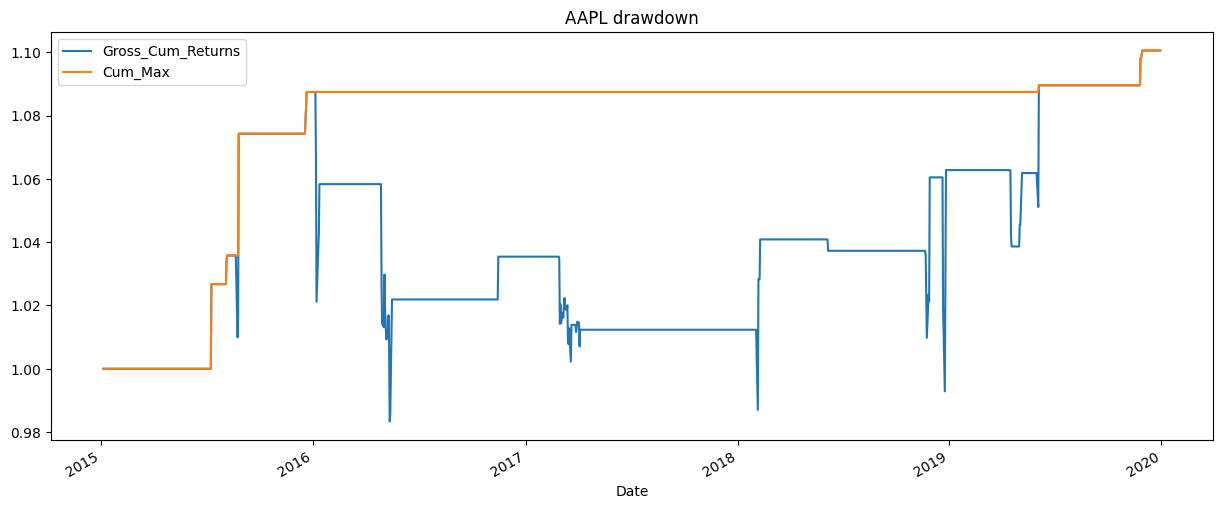

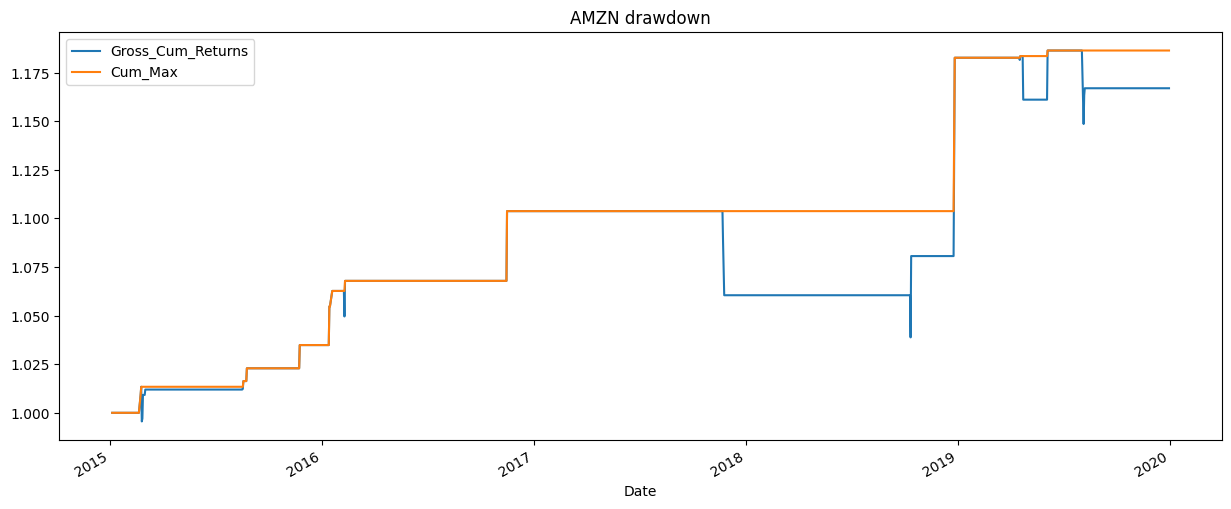

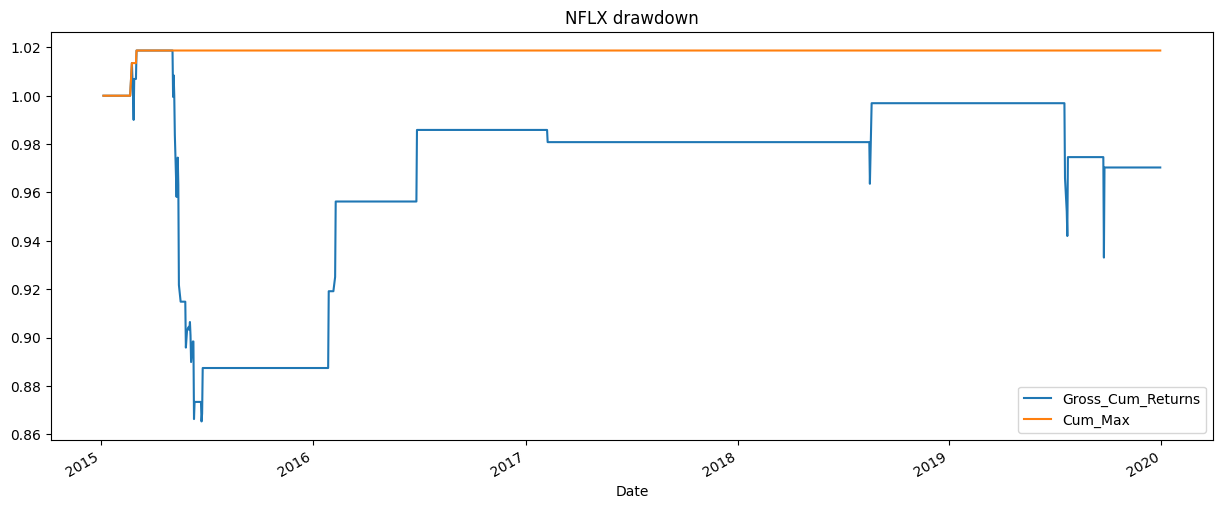

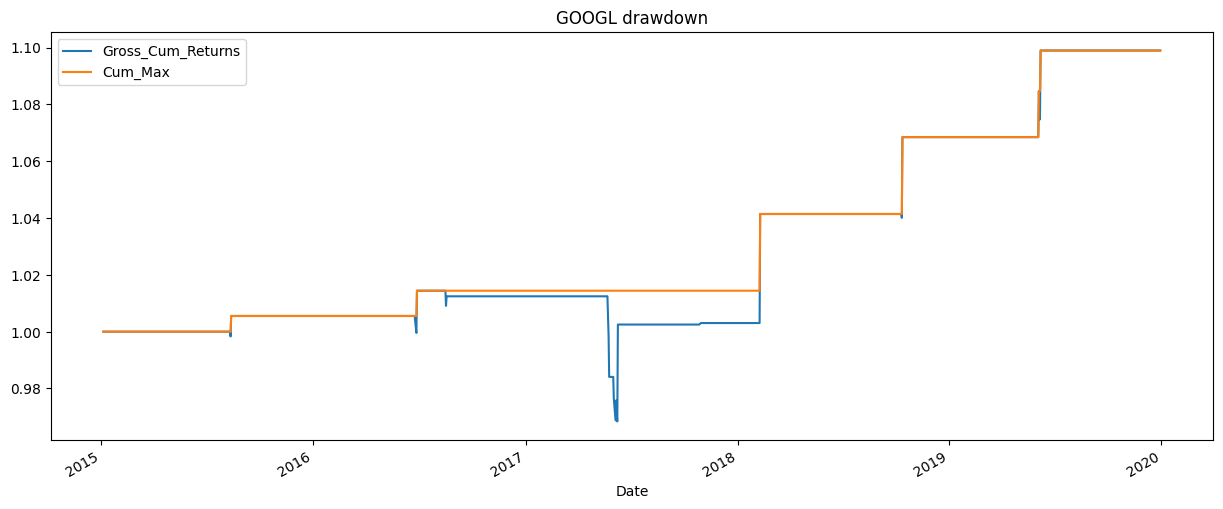

In [ ]:
for stock_name, df in stock_name_and_df_MACD_RSI:
  df["Gross_Cum_Returns"] = df["Strategy Log Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
  df["Cum_Max"] = df["Gross_Cum_Returns"].cummax()
  df[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6), title = f"{stock_name} drawdown")

  drawdown = df["Cum_Max"] - df["Gross_Cum_Returns"] # it gives the difference between orange and blue

  df["drawdown"] = drawdown

  # The maximum difference is refered as "Drawdown"

  max_drawdown = df["drawdown"].max()


  # Although we know the max drawdown, we dont know how long it happened.
  # Lets calculate tha max drawdown period
  # The idea is to store all the points where the blue and orange meet (i.e. gross vs maximum)
  # and then calculate the difference between these points. The highest difference is the longest drawdown period.

  zero_periods = drawdown[drawdown == 0]

  zero_periods

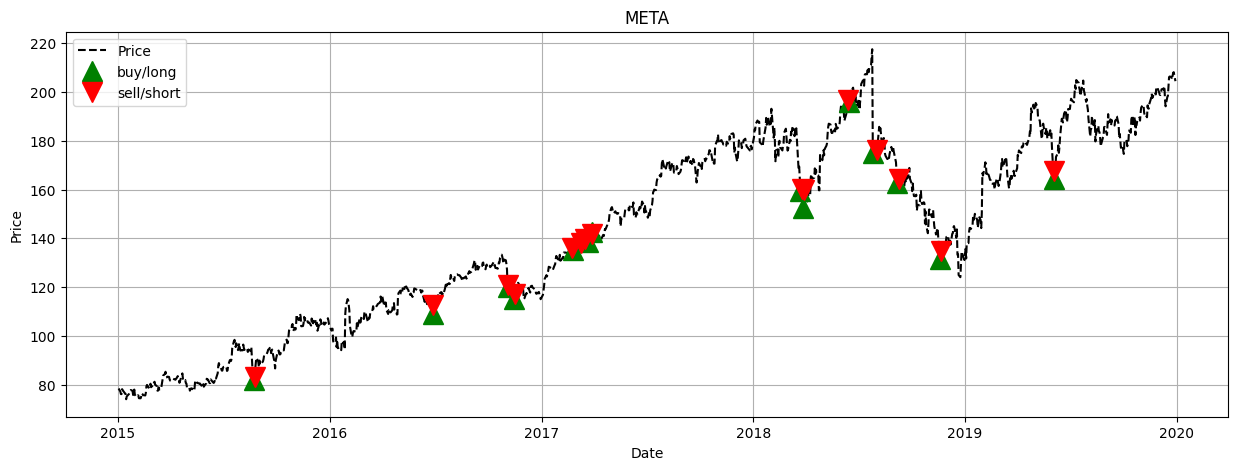

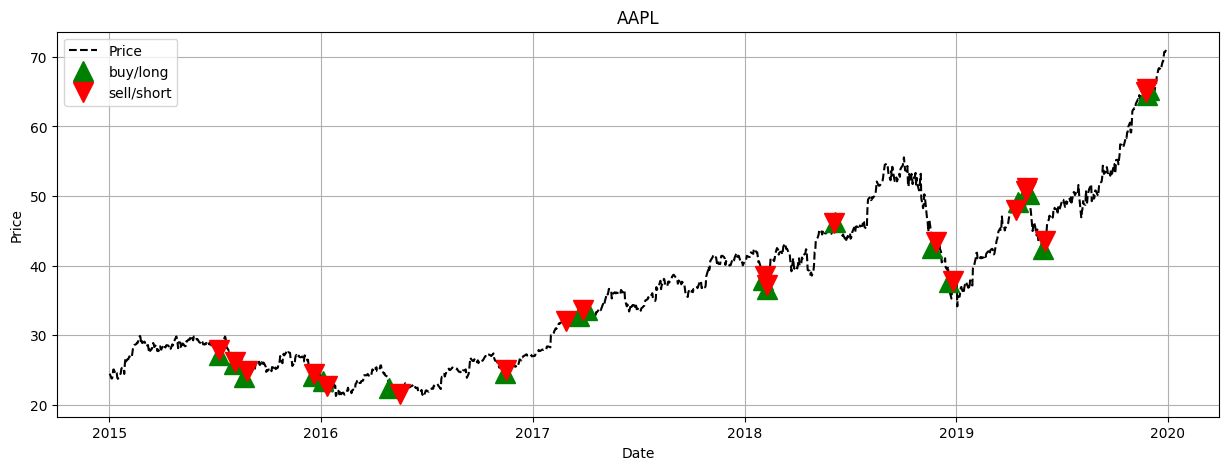

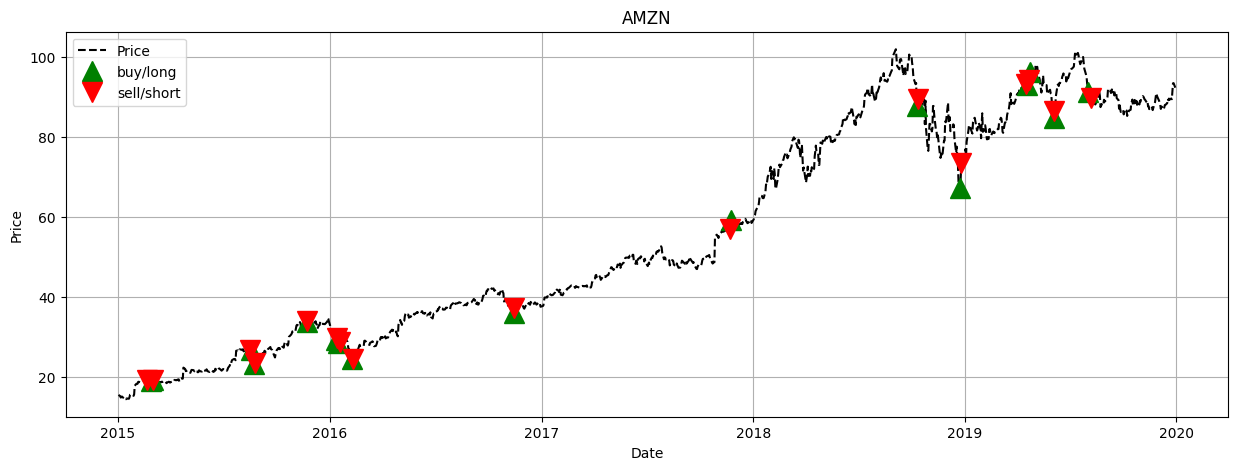

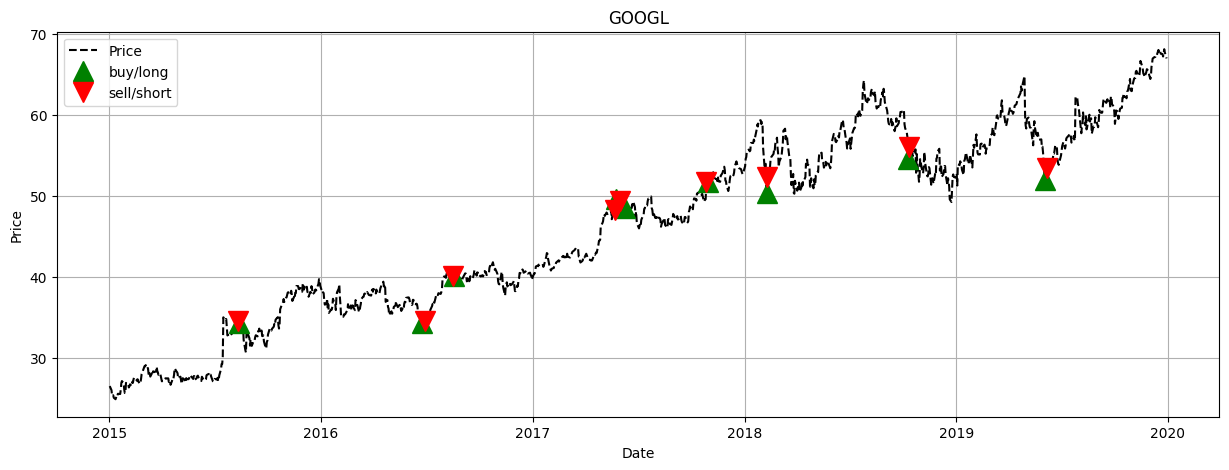

In [ ]:
  # Price and signal plot
for stock_name, df in stock_name_and_df_MACD_RSI:
    plt.figure(figsize=(15, 5))
    plt.plot(df["Close"] ,color='black', label='Price', linestyle='dashed')
    plt.plot(df[df['Signal'] == 1].index,  # plot ‘BUY crossover ’ signals
            df['Close'][df['Signal'] == 1],
            '^', markersize = 15, color = 'g', label = 'buy/long')
    plt.plot(df[df['Signal'] == -1].index,  # plot ‘SELL crossover ’ signals
            df['Close'][df['Signal'] == -1],
            'v', markersize = 15, color = 'r', label = 'sell/short')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("{}".format(stock_name))
    plt.legend()
    plt.grid()
    plt.show()



In [ ]:
 #finding weighted portfolio returns
meta_RSI = stock_name_and_df_MACD_RSI[0][1]
aapl_RSI = stock_name_and_df_MACD_RSI[1][1]
amzn_RSI = stock_name_and_df_MACD_RSI[2][1]
nflx_RSI = stock_name_and_df_MACD_RSI[3][1]
googl_RSI = stock_name_and_df_MACD_RSI[4][1]

MACD_RSI_portfolio_returns= (meta_RSI["Strategy Returns"] + aapl_RSI["Strategy Returns"] + amzn_RSI["Strategy Returns"] + nflx_RSI["Strategy Returns"] + googl_RSI["Strategy Returns"]) / 5
# R = log (R +1)
MACD_RSI_portfolio_returns.apply(np.log1p).sum()


0.10319855889024505

<Axes: title={'center': 'Portfolio Returns (MACD_RSI)'}, xlabel='Date'>

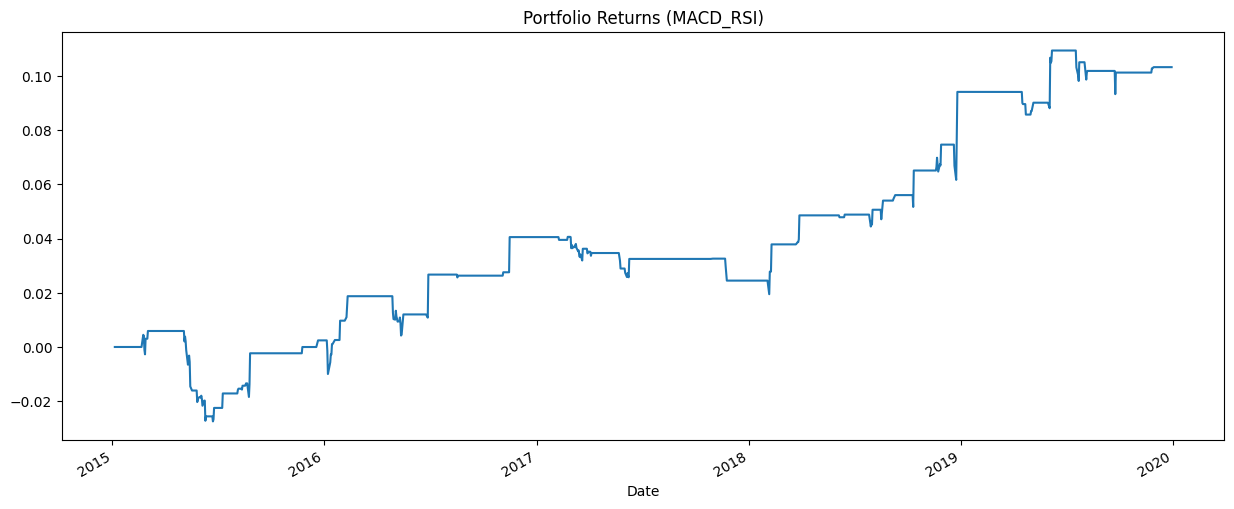

In [ ]:
MACD_RSI_portfolio_returns.apply(np.log1p).cumsum().plot(figsize=(15,6), title = f"Portfolio Returns (MACD_RSI)")

MACD + RSI (only for buy signal)


In [ ]:
def MACD_RSI_backtest_buy(stock_symbol, setting=(26,12,9), RSI_settings = (70,30), start_date="2015-01-01", end_date="2019-12-31"):
    # Fetch historical stock price data for the specified stock symbol and time period
    stock_data = yf.Ticker(stock_symbol)
    historical_data = stock_data.history(start=start_date, end=end_date)

    slow_ema_period = setting[0]
    fast_ema_period = setting[1]
    signal_period = setting[2]

    # Calculate MACD indicators
    macd_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd()
    signal_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_signal()
    histogram = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_diff()

    # Creating RSI indicator
    rsi_indicator = RSIIndicator(close = historical_data['Close'], window= 14, fillna= False)
    daily_rsi = round(rsi_indicator.rsi(),1)

    # Create a DataFrame to store backtesting results
    backtest_df = pd.DataFrame()
    backtest_df["Close"] = historical_data["Close"]
    backtest_df["MACD_Line"] = macd_line
    backtest_df["Signal_Line"] = signal_line
    backtest_df["Histogram"] = histogram
    backtest_df["RSI"] = daily_rsi

    # Generate trading positions based on MACD signals: 1 for Long, -1 for Short
    upper = RSI_settings[0]
    lower = RSI_settings[1]
    backtest_df["Position"] = np.where((backtest_df['MACD_Line'] < backtest_df['Signal_Line'])&(backtest_df["RSI"] < lower) , 1, 0)
    backtest_df["Position"] = np.where((backtest_df['MACD_Line'] < backtest_df['Signal_Line']), -1.0, backtest_df["Position"])

    # Calculate trading signals: difference in positions
    backtest_df["Signal"] = backtest_df['Position'].diff()

    # Compute daily stock returns and strategy returns
    backtest_df['Stock Log Returns'] = np.log(backtest_df["Close"] / backtest_df["Close"].shift(1))
    backtest_df["Strategy Log Returns"] = backtest_df["Stock Log Returns"] * backtest_df["Position"].shift(1)
    backtest_df["Stock Returns"] = (backtest_df["Close"] - backtest_df["Close"].shift(1)) / backtest_df["Close"].shift(1)
    backtest_df["Strategy Returns"] = backtest_df["Stock Returns"] * backtest_df["Position"].shift(1)

    return backtest_df

MAANG_df_list_MACD_RSI_buy = []
for stock in stock_list:
  MAANG_df_list_MACD_RSI_buy.append(MACD_RSI_backtest_buy(stock))

# Zipping the data
stock_name_and_df_MACD_RSI_buy = list(zip(stock_list, MAANG_df_list_MACD_RSI_buy))

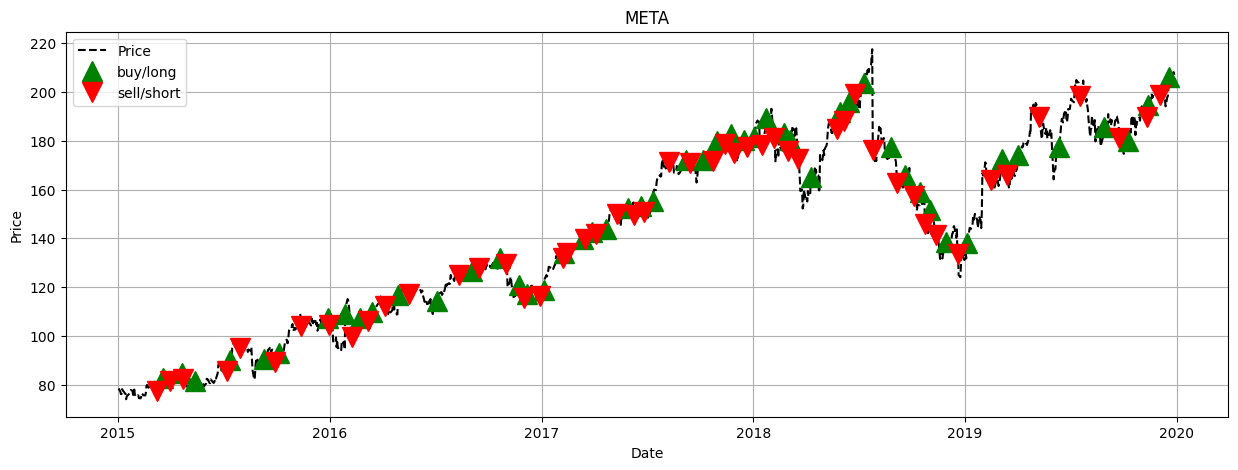

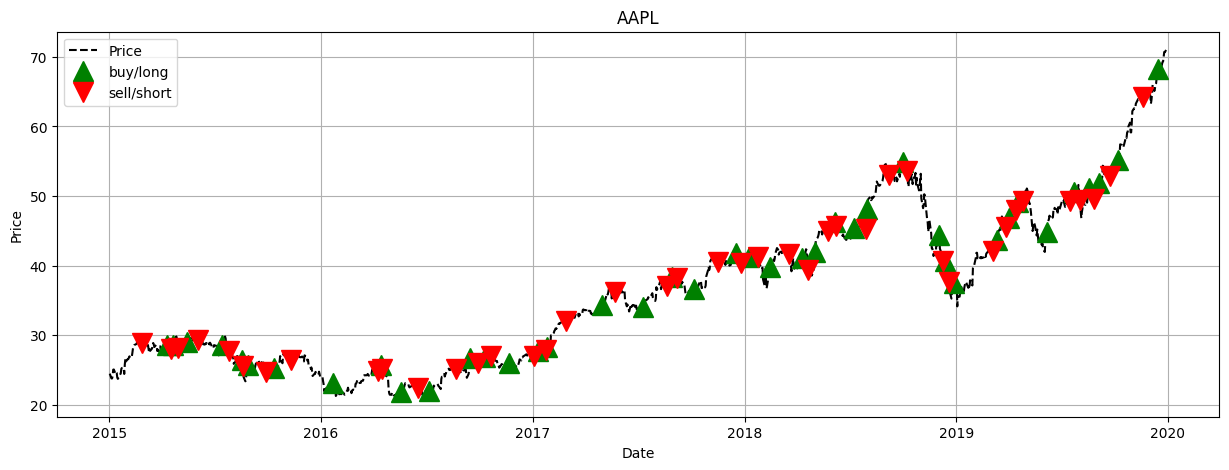

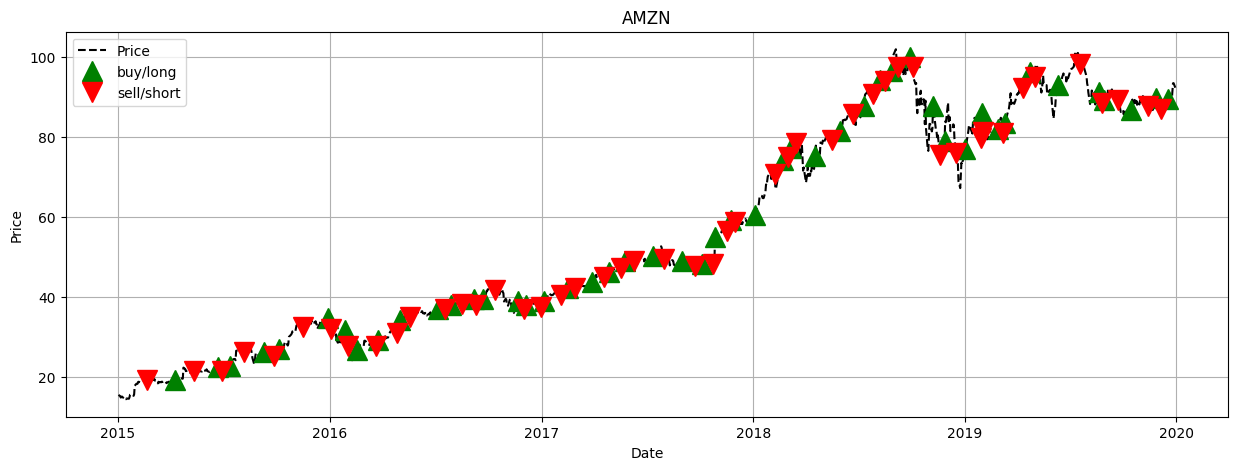

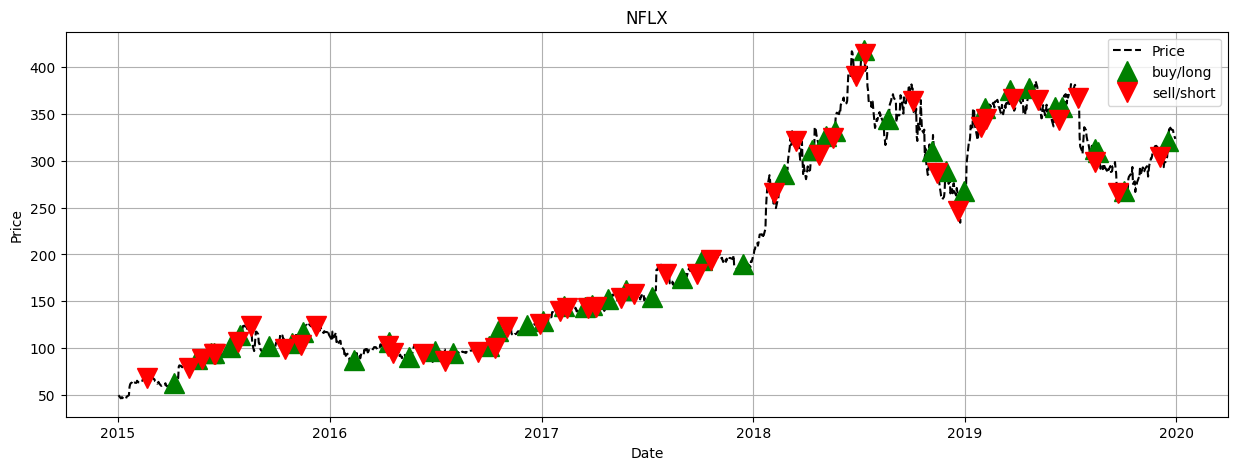

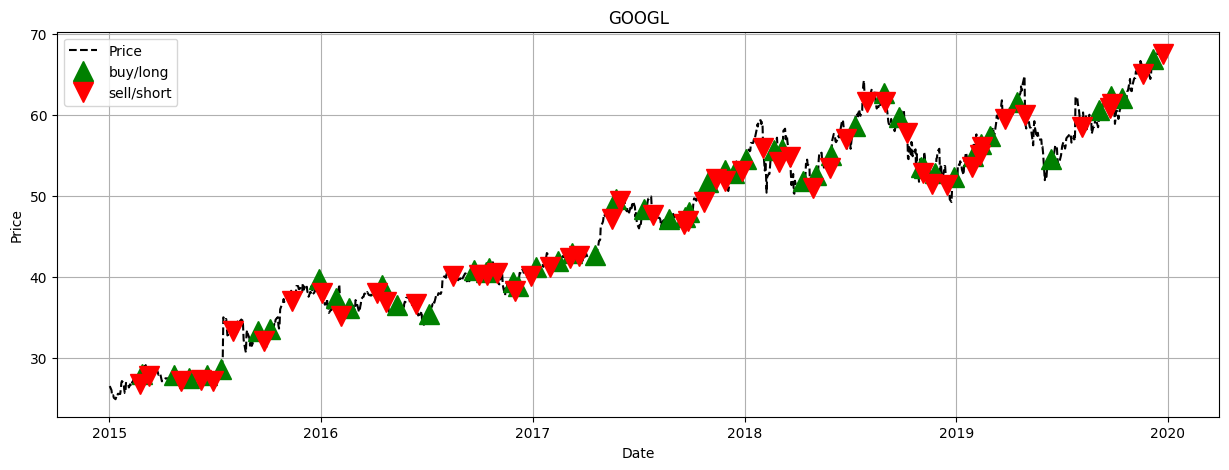

In [ ]:
# Price and signal plot
for stock_name, df in stock_name_and_df_MACD_RSI_buy:
    plt.figure(figsize=(15, 5))
    plt.plot(df["Close"] ,color='black', label='Price', linestyle='dashed')
    plt.plot(df[df['Signal'] == 1].index,  # plot ‘BUY crossover ’ signals
            df['Close'][df['Signal'] == 1],
            '^', markersize = 15, color = 'g', label = 'buy/long')
    plt.plot(df[df['Signal'] == -1].index,  # plot ‘SELL crossover ’ signals
            df['Close'][df['Signal'] == -1],
            'v', markersize = 15, color = 'r', label = 'sell/short')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("{}".format(stock_name))
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
 #finding weighted portfolio returns
meta_RSI_buy = stock_name_and_df_MACD_RSI_buy[0][1]
aapl_RSI_buy = stock_name_and_df_MACD_RSI_buy[1][1]
amzn_RSI_buy = stock_name_and_df_MACD_RSI_buy[2][1]
nflx_RSI_buy = stock_name_and_df_MACD_RSI_buy[3][1]
googl_RSI_buy = stock_name_and_df_MACD_RSI_buy[4][1]

MACD_RSI_buy_portfolio_returns= (meta_RSI_buy["Strategy Returns"] + aapl_RSI_buy["Strategy Returns"] + amzn_RSI_buy["Strategy Returns"] + nflx_RSI_buy["Strategy Returns"] + googl_RSI_buy["Strategy Returns"]) / 5
# R = log (R +1)
portfolio_returns_buy = MACD_RSI_buy_portfolio_returns
portfolio_returns_buy.apply(np.log1p).sum()

-0.829753397165431

<Axes: title={'center': 'Portfolio Returns (MACD_RSI)'}, xlabel='Date'>

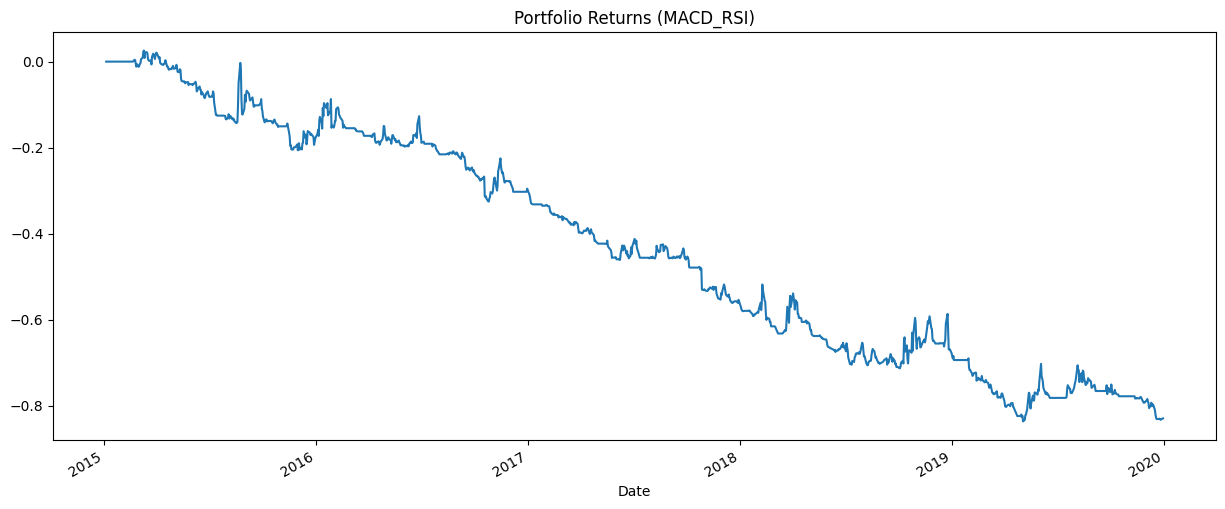

In [ ]:
MACD_RSI_buy_portfolio_returns.apply(np.log1p).cumsum().plot(figsize=(15,6), title = f"Portfolio Returns (MACD_RSI)")

In [ ]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

To convert log returns to regular returns:
Regular returns  = Exp(Log returns) - 1
Log Returns  = Ln(1 + Regular returns)

'''
benchmark_symbol = "^GSPC"
for stock_name, df in stock_name_and_df_MACD_RSI_buy:
  # 1.  Annual Mean Returns or Expected returns
  daily_ret = df[["Stock Log Returns", "Strategy Log Returns"]].mean()
  annual_ret =  daily_ret * 252
  #print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

  # Convert back to regular returns
  # Due to the statistical challenges, we cannot perform calculations on gross returns,
  # Hence, we do that in log returns, and then convert back to regular

  annual_regular_ret = np.exp(annual_ret)-1
  print(f'Annual {stock_name} regular returns are: \n',annual_regular_ret)

  #2. Annual Standard deviation
  daily_std = df[["Stock Log Returns", "Strategy Log Returns"]].std()
  annual_std =  daily_std * (252 **0.5)
  #print(f'Annual log std is: \n', annual_std) # Note that these are the log returns

  #Convert to regular
  daily_regular_std = (np.exp(df[["Stock Log Returns", "Strategy Log Returns"]])-1).std()
  annual_regular_std =  daily_regular_std * (252 **0.5)
  print(f'Annual regular {stock_name} standard deviation is: \n', annual_regular_std) # Note that these are the log returns

  #3. Sharpe Ratio
  # Since we have already calculated the annual returns and risk we can use them

  sr = annual_regular_ret/ annual_regular_std
  print(f" The {stock_name} Sharpe Ratio is : \n ", sr, "\n\n")

Annual META regular returns are: 
 Stock Log Returns       0.211844
Strategy Log Returns   -0.163186
dtype: float64
Annual regular META standard deviation is: 
 Stock Log Returns       0.282297
Strategy Log Returns    0.198799
dtype: float64
 The META Sharpe Ratio is : 
  Stock Log Returns       0.750429
Strategy Log Returns   -0.820861
dtype: float64 


Annual AAPL regular returns are: 
 Stock Log Returns       0.238325
Strategy Log Returns   -0.004132
dtype: float64
Annual regular AAPL standard deviation is: 
 Stock Log Returns       0.248457
Strategy Log Returns    0.183730
dtype: float64
 The AAPL Sharpe Ratio is : 
  Stock Log Returns       0.959222
Strategy Log Returns   -0.022491
dtype: float64 


Annual AMZN regular returns are: 
 Stock Log Returns       0.431946
Strategy Log Returns   -0.197353
dtype: float64
Annual regular AMZN standard deviation is: 
 Stock Log Returns       0.292617
Strategy Log Returns    0.213818
dtype: float64
 The AMZN Sharpe Ratio is : 
  Stock Log Ret

MACD + RSI (only for sell signal)

In [ ]:
def MACD_RSI_backtest_sell(stock_symbol, setting=(26,12,9), RSI_settings = (70,30), start_date="2015-01-01", end_date="2019-12-31"):
    # Fetch historical stock price data for the specified stock symbol and time period
    stock_data = yf.Ticker(stock_symbol)
    historical_data = stock_data.history(start=start_date, end=end_date)

    slow_ema_period = setting[0]
    fast_ema_period = setting[1]
    signal_period = setting[2]

    # Calculate MACD indicators
    macd_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd()
    signal_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_signal()
    histogram = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_diff()

    # Creating RSI indicator
    rsi_indicator = RSIIndicator(close = historical_data['Close'], window= 14, fillna= False)
    daily_rsi = round(rsi_indicator.rsi(),1)

    # Create a DataFrame to store backtesting results
    backtest_df = pd.DataFrame()
    backtest_df["Close"] = historical_data["Close"]
    backtest_df["MACD_Line"] = macd_line
    backtest_df["Signal_Line"] = signal_line
    backtest_df["Histogram"] = histogram
    backtest_df["RSI"] = daily_rsi

    # Generate trading positions based on MACD signals: 1 for Long, -1 for Short
    upper = RSI_settings[0]
    lower = RSI_settings[1]
    backtest_df["Position"] = np.where((backtest_df['MACD_Line'] < backtest_df['Signal_Line']) , 1, 0)
    backtest_df["Position"] = np.where((backtest_df['MACD_Line'] < backtest_df['Signal_Line'])&(backtest_df["RSI"] > upper), -1.0, backtest_df["Position"])

    # Calculate trading signals: difference in positions
    backtest_df["Signal"] = backtest_df['Position'].diff()

    # Compute daily stock returns and strategy returns
    backtest_df['Stock Log Returns'] = np.log(backtest_df["Close"] / backtest_df["Close"].shift(1))
    backtest_df["Strategy Log Returns"] = backtest_df["Stock Log Returns"] * backtest_df["Position"].shift(1)
    backtest_df["Stock Returns"] = (backtest_df["Close"] - backtest_df["Close"].shift(1)) / backtest_df["Close"].shift(1)
    backtest_df["Strategy Returns"] = backtest_df["Stock Returns"] * backtest_df["Position"].shift(1)

    return backtest_df

MAANG_df_list_MACD_RSI_sell = []
for stock in stock_list:
  MAANG_df_list_MACD_RSI_sell.append(MACD_RSI_backtest_sell(stock))

# Zipping the data
stock_name_and_df_MACD_RSI_sell = list(zip(stock_list, MAANG_df_list_MACD_RSI_sell))

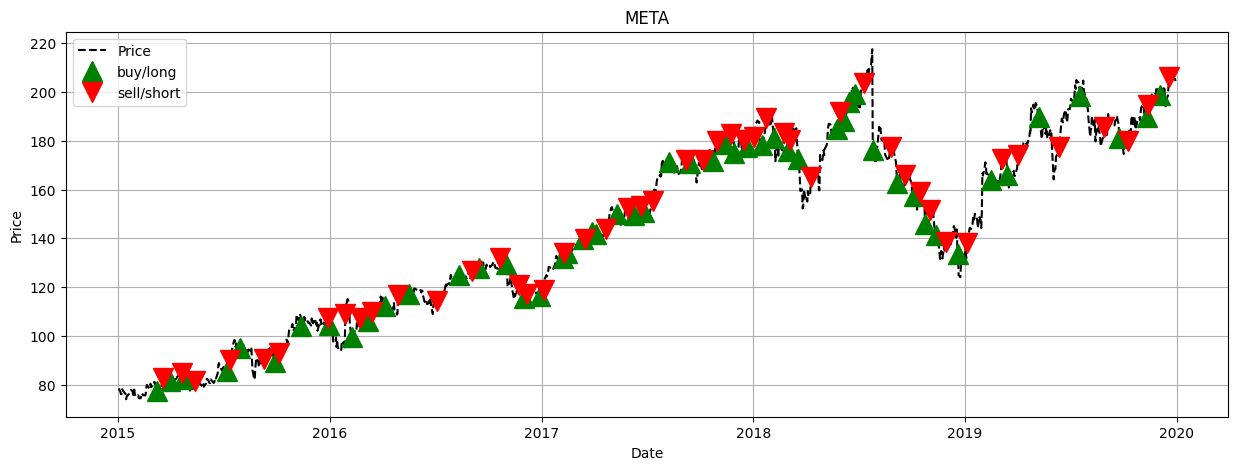

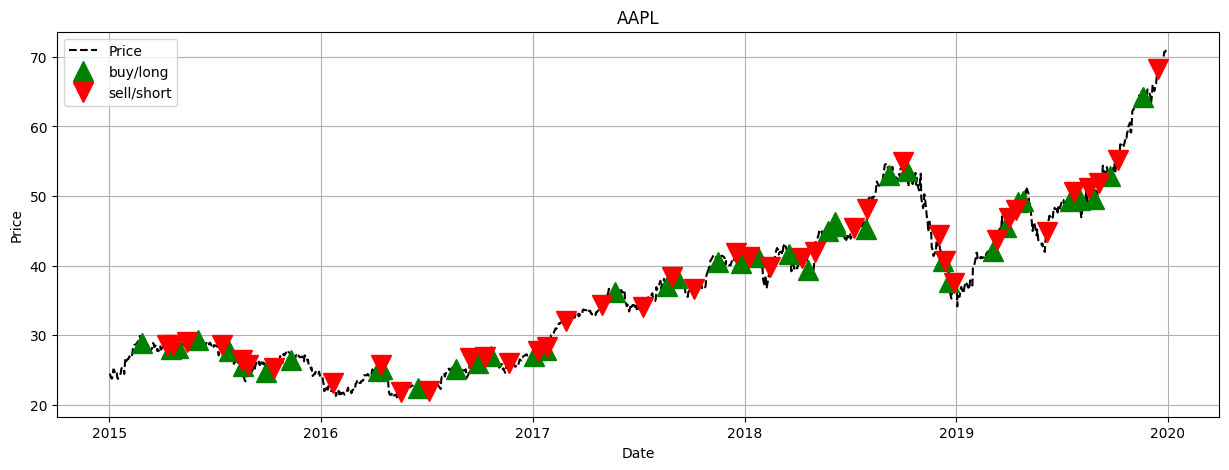

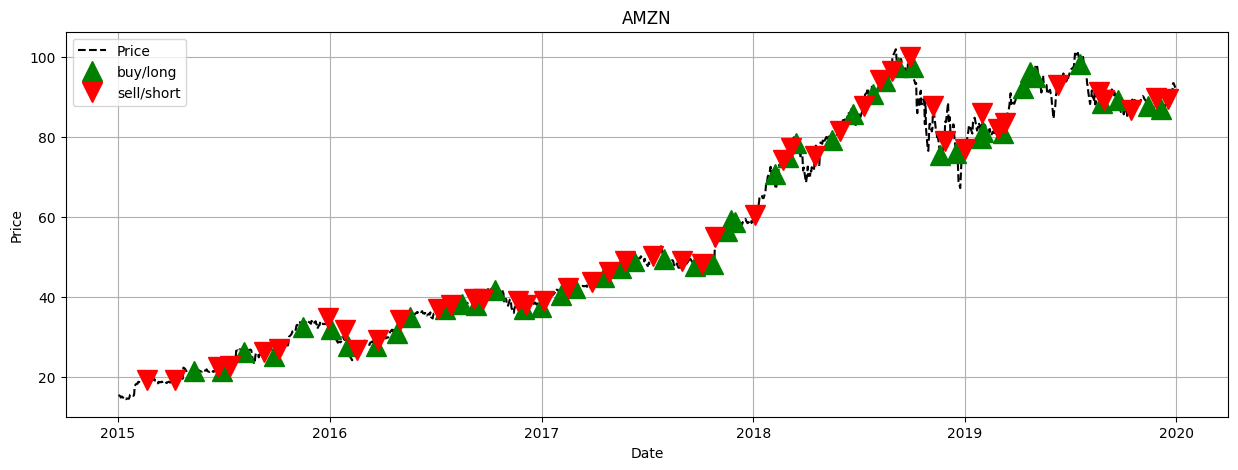

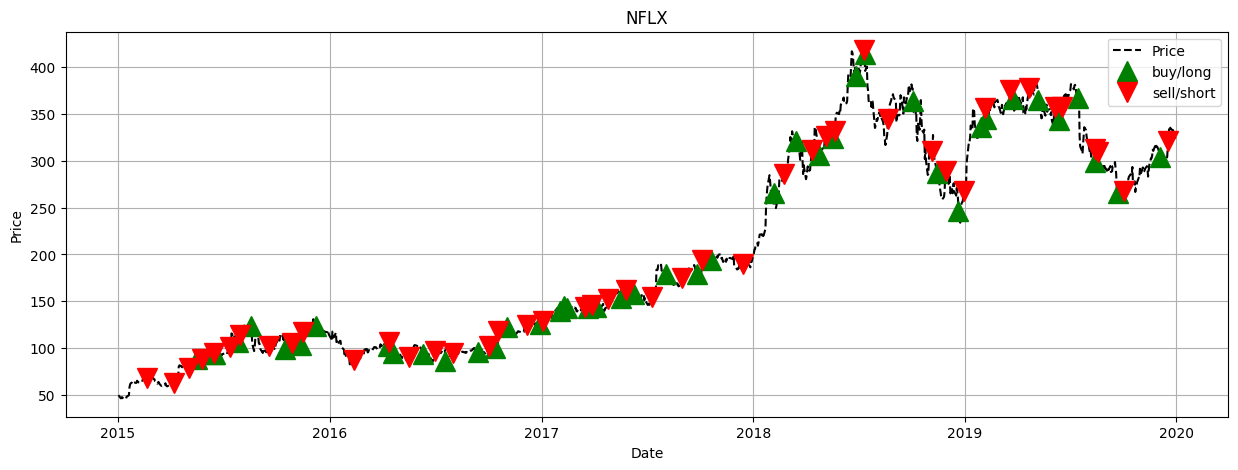

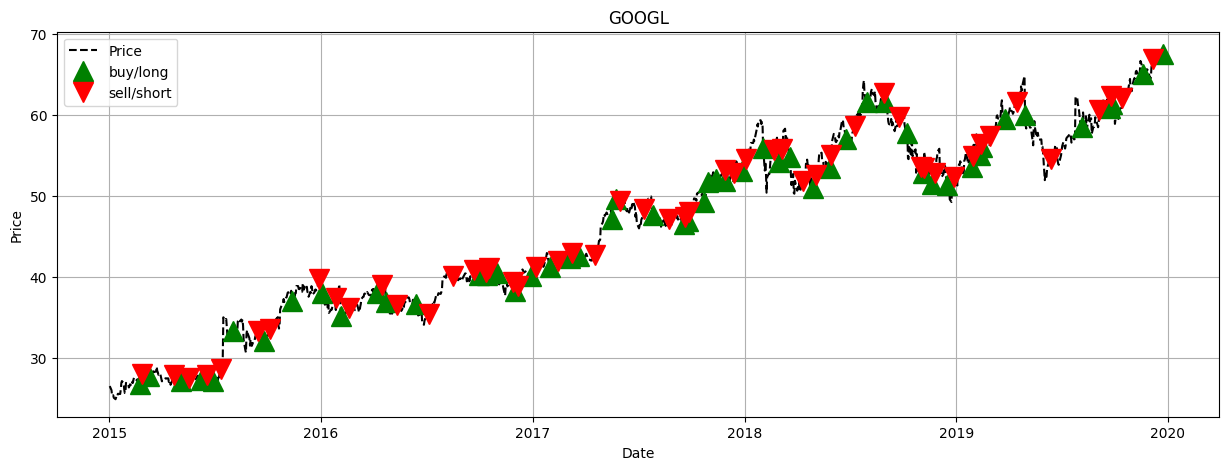

In [ ]:
# Price and signal plot
for stock_name, df in stock_name_and_df_MACD_RSI_sell:
    plt.figure(figsize=(15, 5))
    plt.plot(df["Close"] ,color='black', label='Price', linestyle='dashed')
    plt.plot(df[df['Signal'] == 1].index,  # plot ‘BUY crossover ’ signals
            df['Close'][df['Signal'] == 1],
            '^', markersize = 15, color = 'g', label = 'buy/long')
    plt.plot(df[df['Signal'] == -1].index,  # plot ‘SELL crossover ’ signals
            df['Close'][df['Signal'] == -1],
            'v', markersize = 15, color = 'r', label = 'sell/short')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("{}".format(stock_name))
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
 #finding weighted portfolio returns
meta_RSI_sell = stock_name_and_df_MACD_RSI_sell[0][1]
aapl_RSI_sell = stock_name_and_df_MACD_RSI_sell[1][1]
amzn_RSI_sell = stock_name_and_df_MACD_RSI_sell[2][1]
nflx_RSI_sell = stock_name_and_df_MACD_RSI_sell[3][1]
googl_RSI_sell = stock_name_and_df_MACD_RSI_sell[4][1]

MACD_RSI_sell_portfolio_returns= (meta_RSI_sell["Strategy Returns"] + aapl_RSI_sell["Strategy Returns"] + amzn_RSI_sell["Strategy Returns"] + nflx_RSI_sell["Strategy Returns"] + googl_RSI_sell["Strategy Returns"]) / 5
# R = log (R +1)
portfolio_returns_sell = MACD_RSI_sell_portfolio_returns
portfolio_returns_sell.apply(np.log1p).sum()

0.6282105066023408

<Axes: title={'center': 'Portfolio Returns (MACD_RSI)'}, xlabel='Date'>

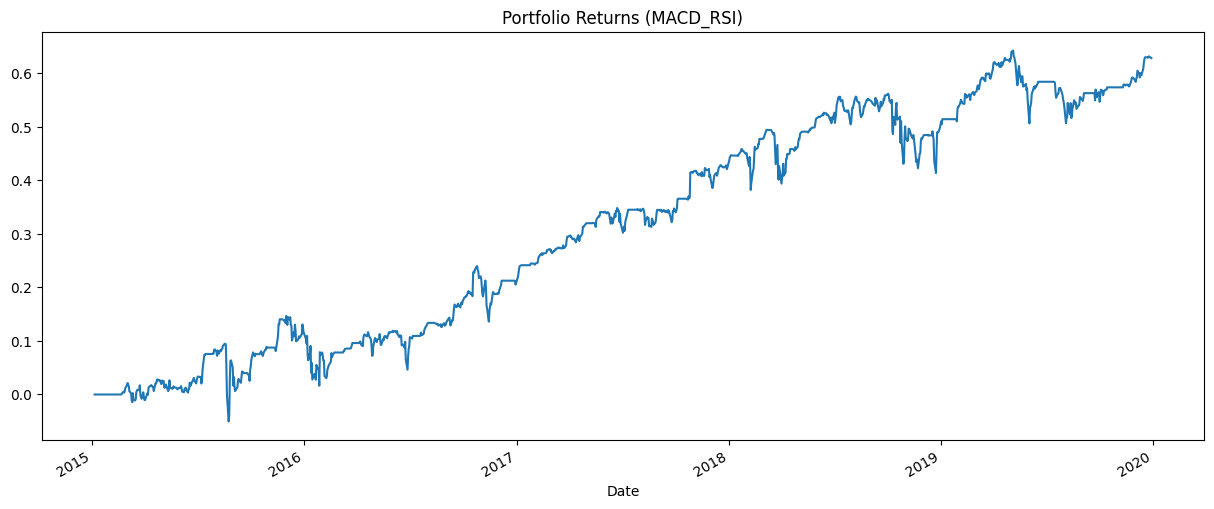

In [ ]:
MACD_RSI_sell_portfolio_returns.apply(np.log1p).cumsum().plot(figsize=(15,6), title = f"Portfolio Returns (MACD_RSI)")

In [ ]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

To convert log returns to regular returns:
Regular returns  = Exp(Log returns) - 1
Log Returns  = Ln(1 + Regular returns)

'''
benchmark_symbol = "^GSPC"
for stock_name, df in stock_name_and_df_MACD_RSI_sell:
  # 1.  Annual Mean Returns or Expected returns
  daily_ret = df[["Stock Log Returns", "Strategy Log Returns"]].mean()
  annual_ret =  daily_ret * 252
  #print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

  # Convert back to regular returns
  # Due to the statistical challenges, we cannot perform calculations on gross returns,
  # Hence, we do that in log returns, and then convert back to regular

  annual_regular_ret = np.exp(annual_ret)-1
  print(f'Annual {stock_name} regular returns are: \n',annual_regular_ret)

  #2. Annual Standard deviation
  daily_std = df[["Stock Log Returns", "Strategy Log Returns"]].std()
  annual_std =  daily_std * (252 **0.5)
  #print(f'Annual log std is: \n', annual_std) # Note that these are the log returns

  #Convert to regular
  daily_regular_std = (np.exp(df[["Stock Log Returns", "Strategy Log Returns"]])-1).std()
  annual_regular_std =  daily_regular_std * (252 **0.5)
  print(f'Annual regular {stock_name} standard deviation is: \n', annual_regular_std) # Note that these are the log returns

  #3. Sharpe Ratio
  # Since we have already calculated the annual returns and risk we can use them

  sr = annual_regular_ret/ annual_regular_std
  print(f" The {stock_name} Sharpe Ratio is : \n ", sr, "\n\n")

Annual META regular returns are: 
 Stock Log Returns       0.211844
Strategy Log Returns    0.196927
dtype: float64
Annual regular META standard deviation is: 
 Stock Log Returns       0.282297
Strategy Log Returns    0.201273
dtype: float64
 The META Sharpe Ratio is : 
  Stock Log Returns       0.750429
Strategy Log Returns    0.978408
dtype: float64 


Annual AAPL regular returns are: 
 Stock Log Returns       0.238325
Strategy Log Returns   -0.002619
dtype: float64
Annual regular AAPL standard deviation is: 
 Stock Log Returns       0.248457
Strategy Log Returns    0.183026
dtype: float64
 The AAPL Sharpe Ratio is : 
  Stock Log Returns       0.959222
Strategy Log Returns   -0.014311
dtype: float64 


Annual AMZN regular returns are: 
 Stock Log Returns       0.431946
Strategy Log Returns    0.230672
dtype: float64
Annual regular AMZN standard deviation is: 
 Stock Log Returns       0.292617
Strategy Log Returns    0.216301
dtype: float64
 The AMZN Sharpe Ratio is : 
  Stock Log Ret

Variation 3: MACD + Bollinger Bands


In [ ]:
# Define a custom function for MACD-based backtesting
def MACD_BB_backtest(stock_symbol, setting=(26,12,9), start_date="2015-01-01", end_date="2019-12-31"):
    # Fetch historical stock price data for the specified stock symbol and time period
    stock_data = yf.Ticker(stock_symbol)
    historical_data = stock_data.history(start=start_date, end=end_date)

    slow_ema_period = setting[0]
    fast_ema_period = setting[1]
    signal_period = setting[2]

    # Calculate MACD indicators
    macd_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd()
    signal_line = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_signal()
    histogram = MACD(close=historical_data["Close"], window_slow=slow_ema_period, window_fast=fast_ema_period, window_sign=signal_period, fillna=False).macd_diff()

    # Creating BB indicator
    BB_indicator = BollingerBands(close = historical_data['Close'], window = 20, window_dev = 2.0, fillna = False)
    daily_BB_mAvg = round(BB_indicator.bollinger_mavg(),1)
    daily_BB_high = round(BB_indicator.bollinger_hband(),1)
    daily_BB_low = round(BB_indicator.bollinger_lband(),1)
    daily_BB_buy = round(BB_indicator.bollinger_hband_indicator(),1)
    daily_BB_sell = round(BB_indicator.bollinger_lband_indicator(),1)

    # Create a DataFrame to store backtesting results
    backtest_df = pd.DataFrame()
    backtest_df["Close"] = historical_data["Close"]
    backtest_df["MACD_Line"] = macd_line
    backtest_df["Signal_Line"] = signal_line
    backtest_df["Histogram"] = histogram
    backtest_df["BB"] = daily_BB_mAvg
    backtest_df["BB_high"] = daily_BB_high
    backtest_df["BB_low"] = daily_BB_low
    backtest_df["BB_buy"] = daily_BB_buy
    backtest_df["BB_sell"] = daily_BB_sell

    # Generate trading positions based on MACD signals: 1 for Long, -1 for Short
    #first criteria focused on mean reversion, then addressing breakout
    backtest_df["Position"] = np.where(((backtest_df['MACD_Line'] > backtest_df['Signal_Line']) & (backtest_df["Close"] < backtest_df["BB_low"])) | ((backtest_df['MACD_Line'] > backtest_df['Signal_Line']) & (backtest_df["Close"] > backtest_df["BB_high"])), 1.0, 0)
    backtest_df["Position"] = np.where(((backtest_df['MACD_Line'] < backtest_df['Signal_Line']) & (backtest_df["Close"] > backtest_df["BB_high"])) | ((backtest_df['MACD_Line'] < backtest_df['Signal_Line']) & (backtest_df["Close"] < backtest_df["BB_low"])), -1.0, backtest_df["Position"])


    # Calculate trading signals: difference in positions
    backtest_df["Signal"] = backtest_df['Position'].diff()

    # Compute daily stock returns and strategy returns
    backtest_df['Stock Log Returns'] = np.log(backtest_df["Close"] / backtest_df["Close"].shift(1))
    backtest_df["Strategy Log Returns"] = backtest_df["Stock Log Returns"] * backtest_df["Position"].shift(1)
    backtest_df["Stock Returns"] = (backtest_df["Close"] - backtest_df["Close"].shift(1)) / backtest_df["Close"].shift(1)
    backtest_df["Strategy Returns"] = backtest_df["Stock Returns"] * backtest_df["Position"].shift(1)

    # backtest_df["Stock Returns"] = (backtest_df["Close"] - backtest_df["Close"].shift(1)) / backtest_df["Close"].shift(1)
    # backtest_df["Stock Log Returns"] = np.log(backtest_df["Close"] / backtest_df["Close"].shift(1))
    # backtest_df["Strategy Returns"] = backtest_df["Stock Returns"] * backtest_df["Position"]
    # backtest_df["Strategy Log Returns"] = backtest_df["Stock Log Returns"] * backtest_df["Position"]

    return backtest_df

In [ ]:
MAANG_df_list_MACD = []
stock_list = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]
MAANG_df_list_MACD_BB = []
for stock in stock_list:
  MAANG_df_list_MACD_BB.append(MACD_BB_backtest(stock))

# Zipping the data
stock_name_and_df_MACD_BB = list(zip(stock_list, MAANG_df_list_MACD_BB))

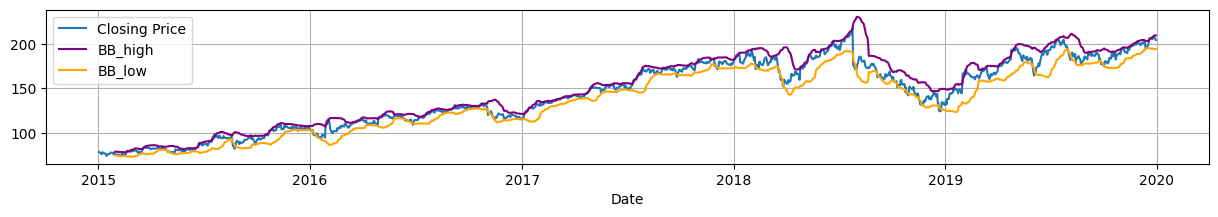

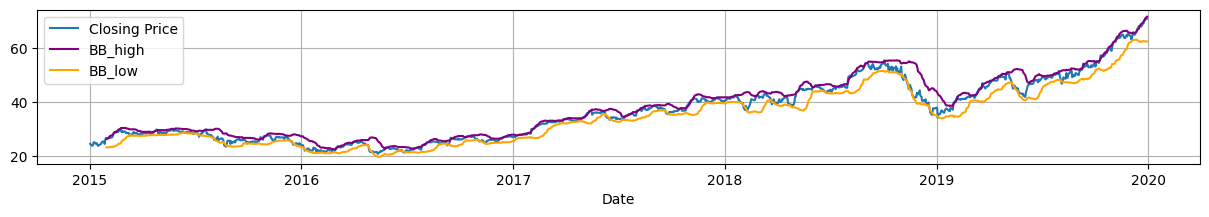

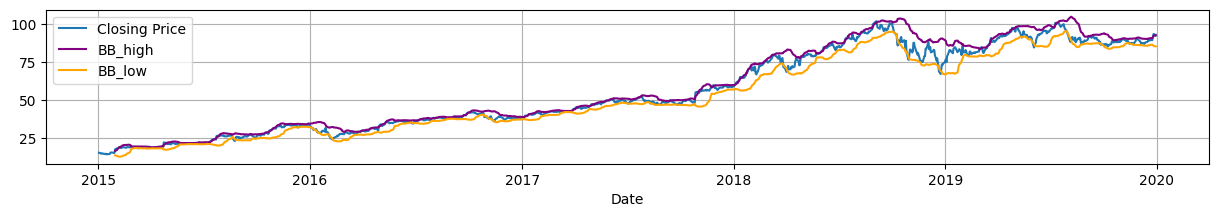

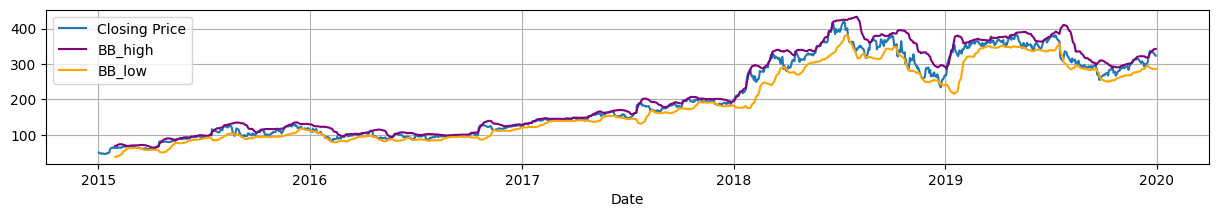

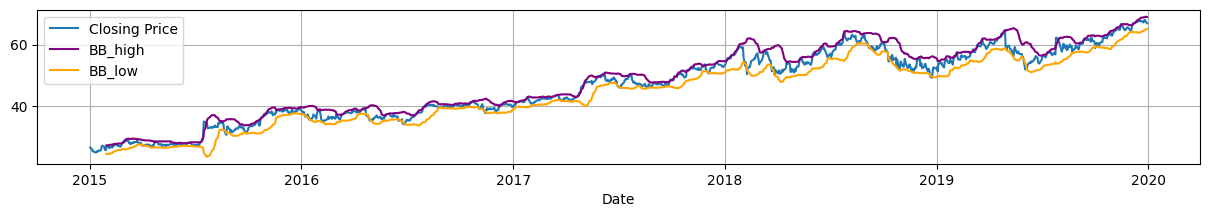

In [ ]:
# BB plot
for stock_name, s in stock_name_and_df_MACD_BB:
    plt.figure(figsize=(15, 2))
    plt.plot(s['Close'], label='Closing Price')
    plt.plot(s['BB_high'], color = 'purple', label='BB_high')
    plt.plot(s['BB_low'], color = 'orange',label='BB_low')
    plt.xlabel('Date')
    plt.legend()
    plt.grid()
    plt.show()

# BB plot

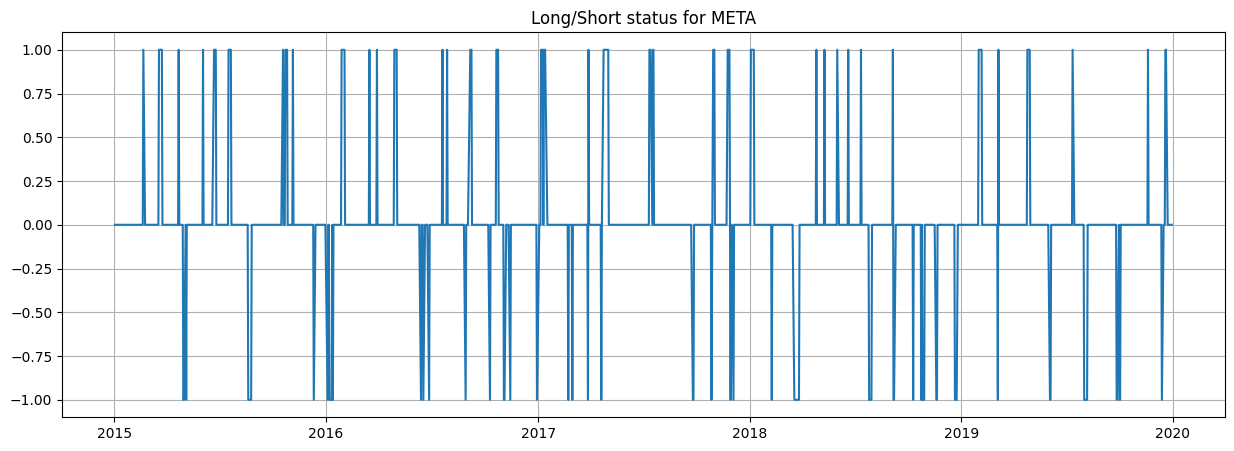

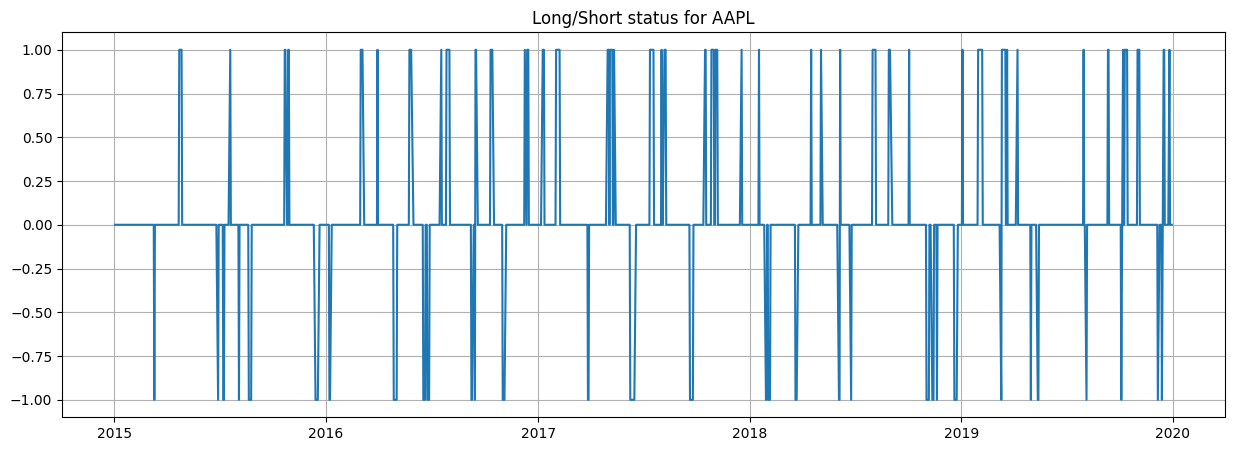

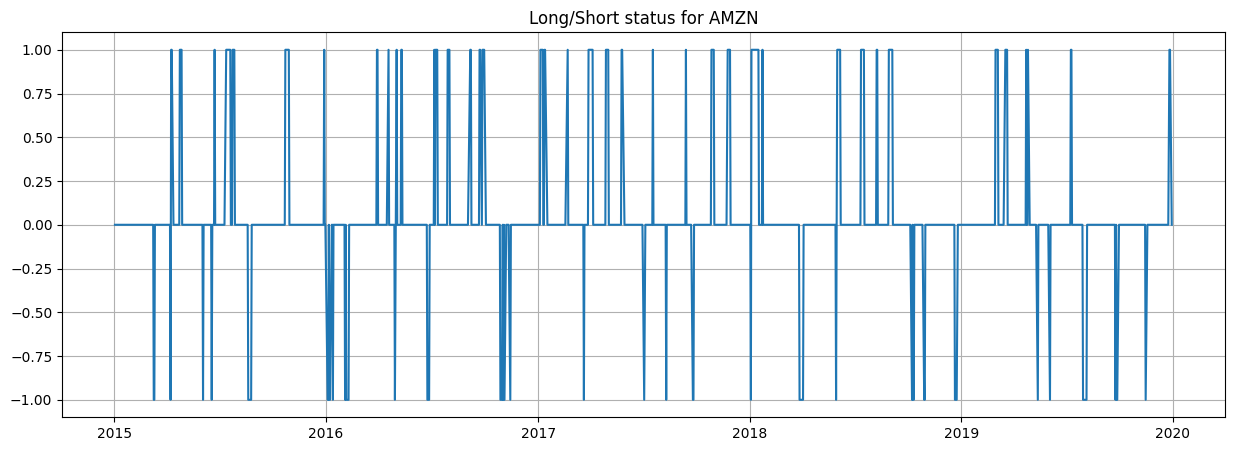

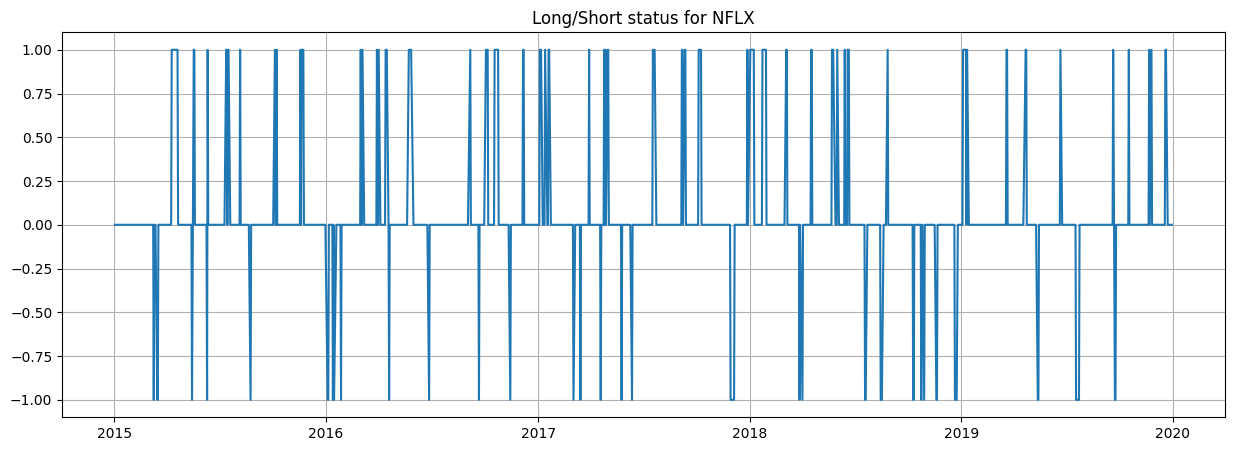

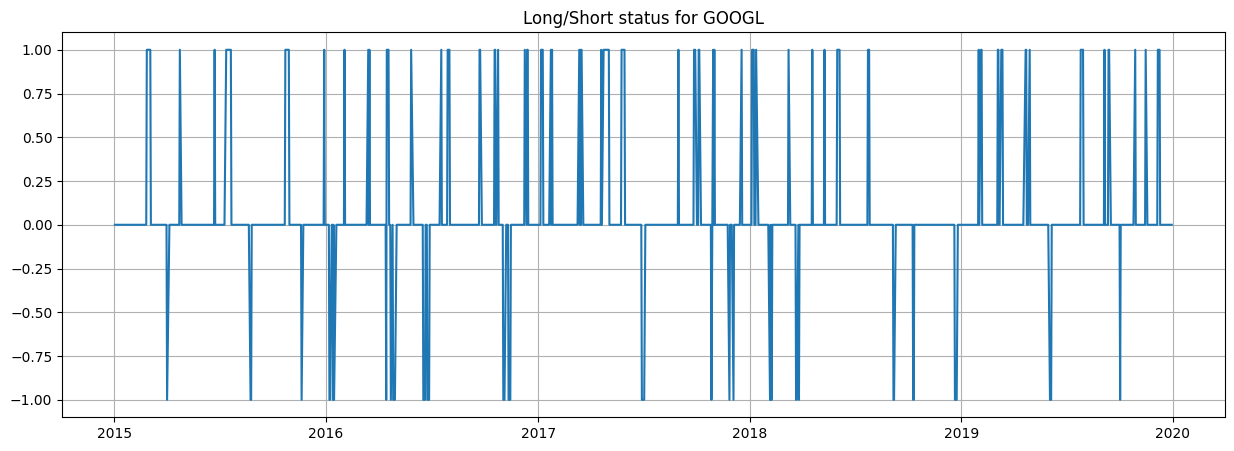

In [ ]:
# Plotting Long/Short Status for the stocks
for stock_name, s  in stock_name_and_df_MACD_BB:
  plt.figure(figsize=(15,5))
  plt.plot(s["Position"])
  plt.title(f"Long/Short status for {stock_name}")
  plt.grid()
  plt.show()

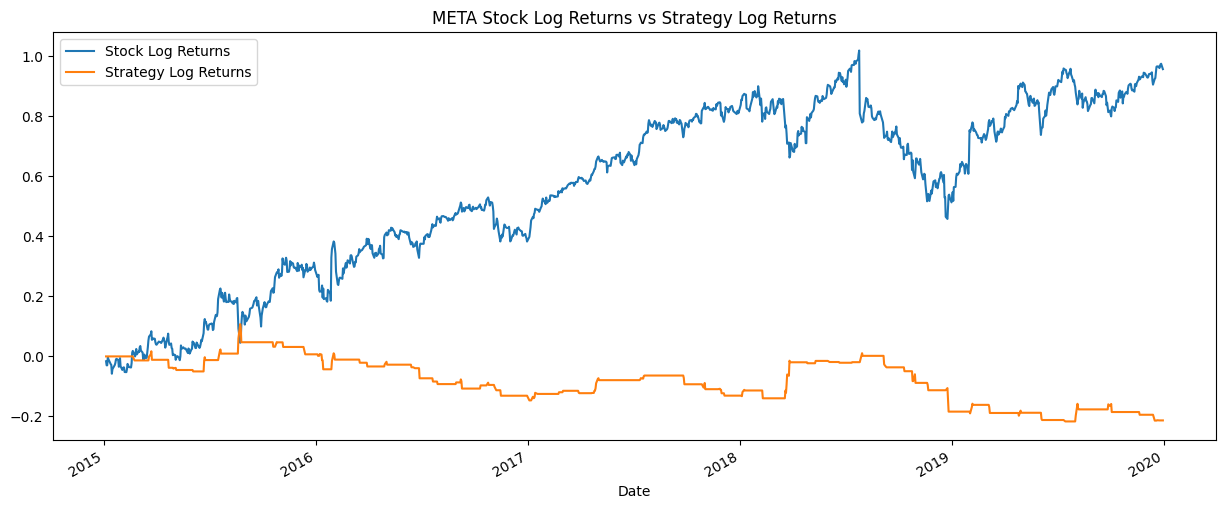

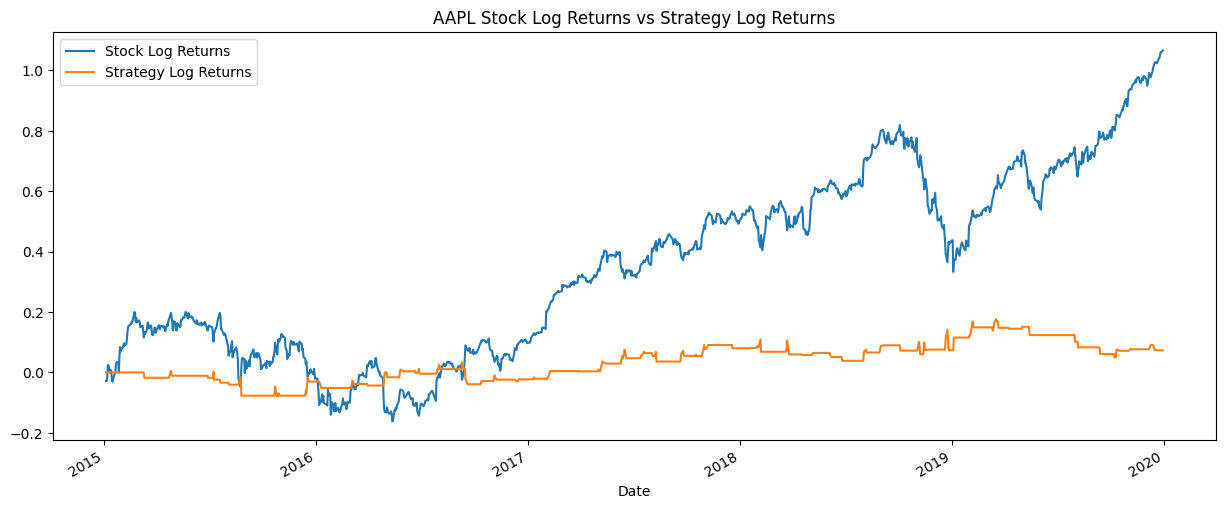

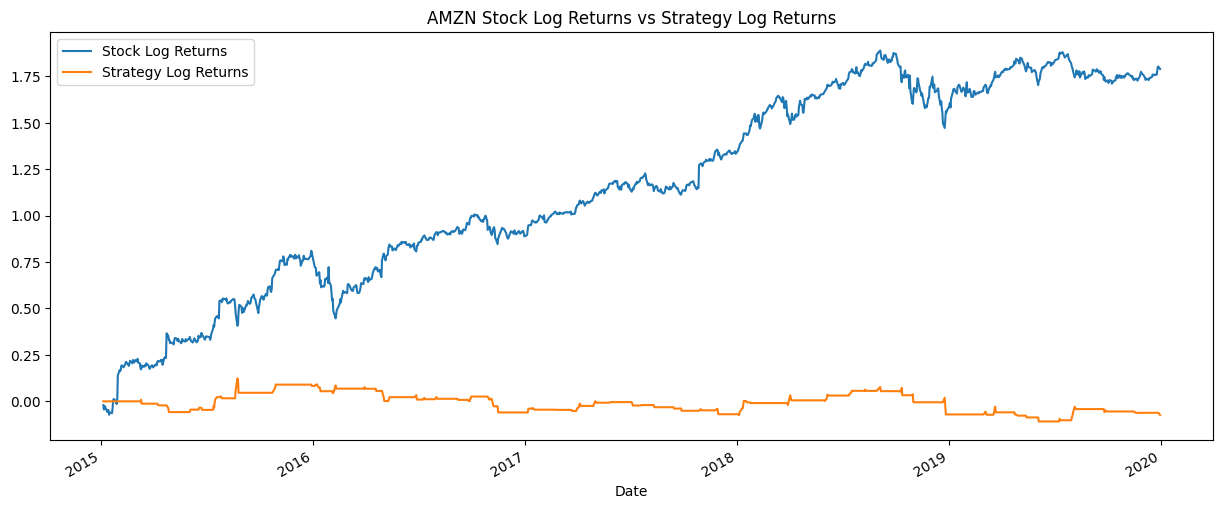

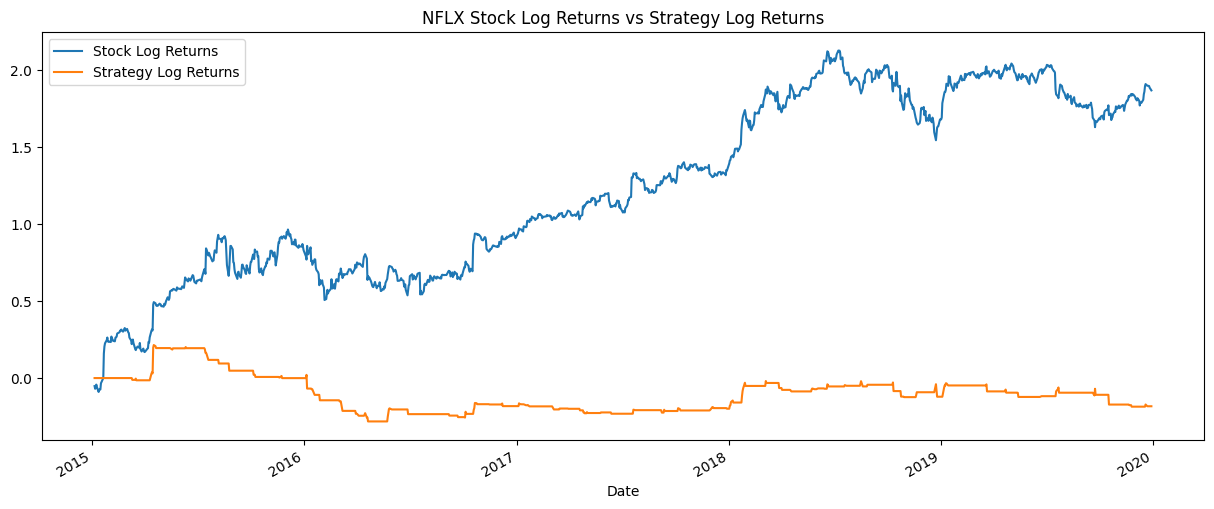

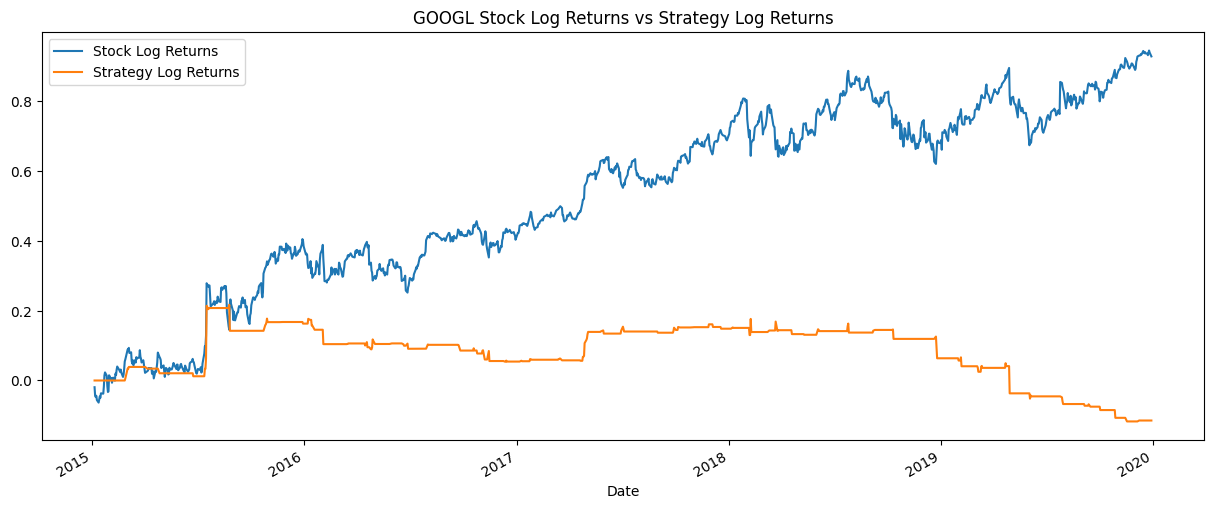

In [ ]:
# Plotting the Stock Log Returns vs Strategy Log Returns
for stock_name, df in stock_name_and_df_MACD_BB:
  df[["Stock Log Returns", "Strategy Log Returns"]].cumsum().plot(figsize=(15,6), title = f"{stock_name} Stock Log Returns vs Strategy Log Returns")

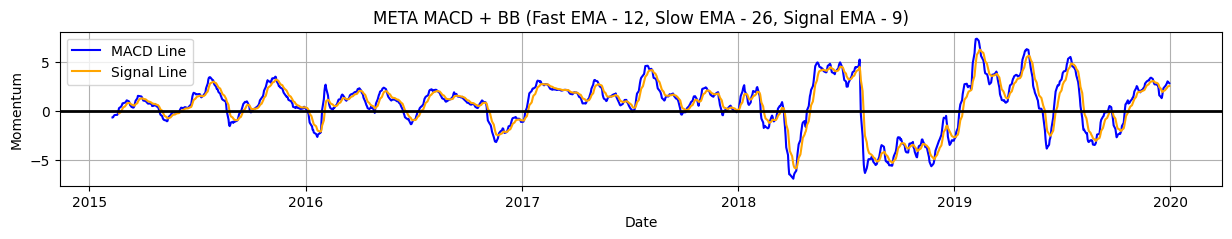

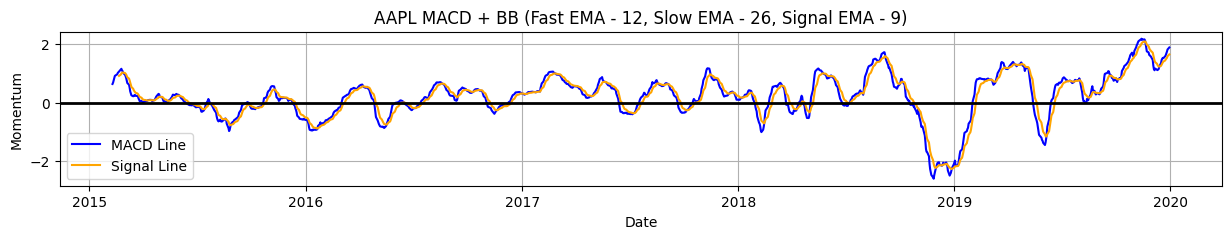

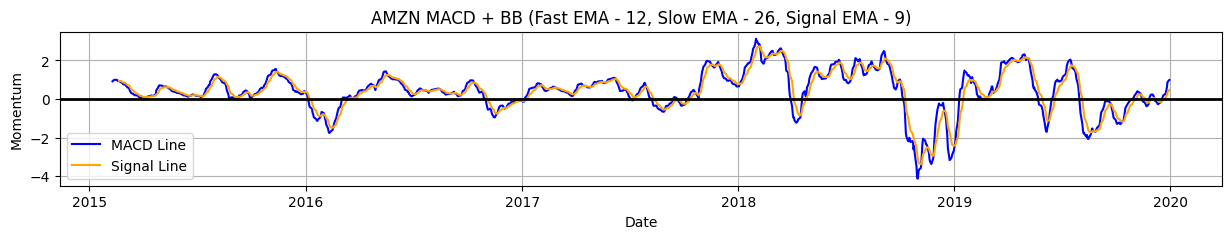

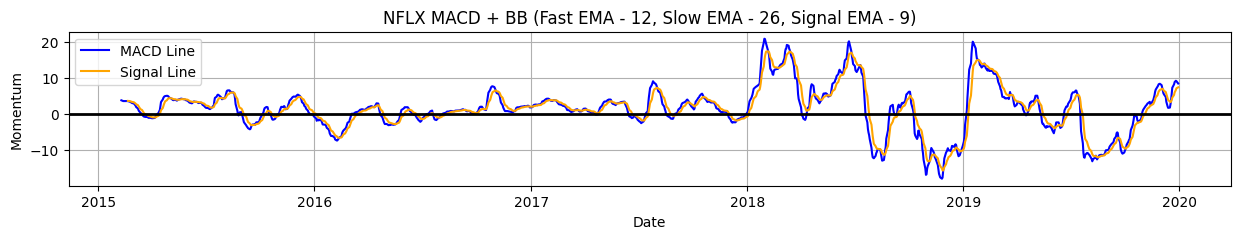

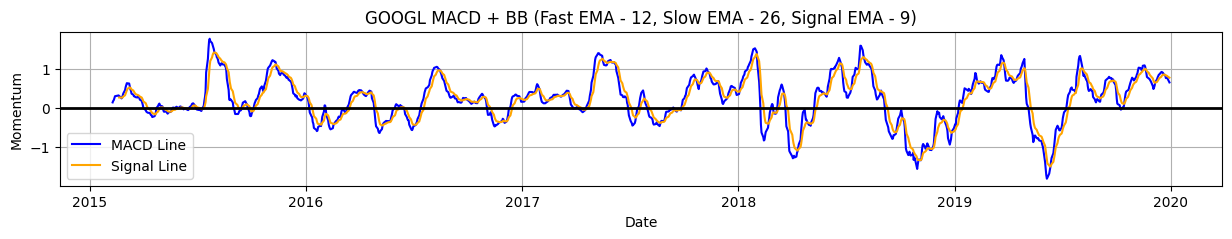

In [ ]:
# MACD Plot
for stock_name, s  in stock_name_and_df_MACD_BB:
  slow_ema_period = 26
  fast_ema_period = 12
  signal_period = 9


  plt.figure(figsize=(15, 2))
  plt.plot(s["MACD_Line"], color='blue', label='MACD Line')
  plt.plot(s["Signal_Line"], color='orange', label='Signal Line')
  plt.axhline(y=0,color='black', linestyle='-', linewidth=2)
  plt.xlabel("Date")
  plt.ylabel("Momentum")
  plt.title("{} MACD + BB (Fast EMA - {}, Slow EMA - {}, Signal EMA - {})".format(stock_name, fast_ema_period, slow_ema_period, signal_period))
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
#calculation of returns
for stock_name, df in stock_name_and_df_MACD_BB:
  final_stock_return = (df["Stock Log Returns"].sum())
  final_strategy_return = (df["Strategy Log Returns"].sum())
  print(f"{stock_name} final_stock_return {final_stock_return}")
  print(f"{stock_name} final_strategy_return {final_strategy_return} \n")


META final_stock_return 0.9576663584490293
META final_strategy_return -0.21338949319723477 

AAPL final_stock_return 1.0654056480374128
AAPL final_strategy_return 0.0727687104711489 

AMZN final_stock_return 1.78947174945224
AMZN final_strategy_return -0.0739997835477075 

NFLX final_stock_return 1.8696217621324844
NFLX final_strategy_return -0.18320206912121226 

GOOGL final_stock_return 0.9281807758088632
GOOGL final_strategy_return -0.1146218009651026 



In [ ]:
#finding weighted portfolio returns
meta = stock_name_and_df_MACD_BB[0][1]
aapl = stock_name_and_df_MACD_BB[1][1]
amzn = stock_name_and_df_MACD_BB[2][1]
nflx = stock_name_and_df_MACD_BB[3][1]
googl = stock_name_and_df_MACD_BB[4][1]

stock_portfolio_returns= (meta["Stock Returns"] + aapl["Stock Returns"] + amzn["Stock Returns"] + nflx["Stock Returns"] + googl["Stock Returns"]) / 5
MACD_BB_portfolio_returns= (meta["Strategy Returns"] + aapl["Strategy Returns"] + amzn["Strategy Returns"] + nflx["Strategy Returns"] + googl["Strategy Returns"]) / 5
# R = log (R +1)

stock_weighted_returns = stock_portfolio_returns.apply(np.log1p).sum()
SUM_MACD_BB_portfolio_returns = MACD_BB_portfolio_returns.apply(np.log1p).sum()
print(SUM_MACD_BB_portfolio_returns)



-0.11600012859123349


<Axes: title={'center': 'Portfolio Returns (MACD_BB)'}, xlabel='Date'>

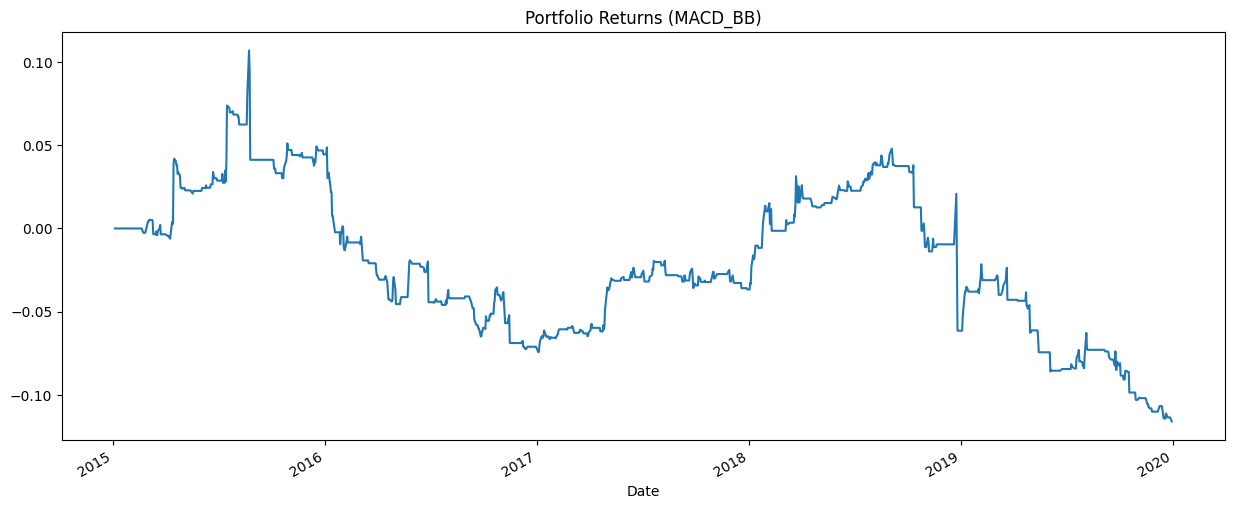

In [ ]:
MACD_BB_portfolio_returns.apply(np.log1p).cumsum().plot(figsize=(15,6), title = f"Portfolio Returns (MACD_BB)")

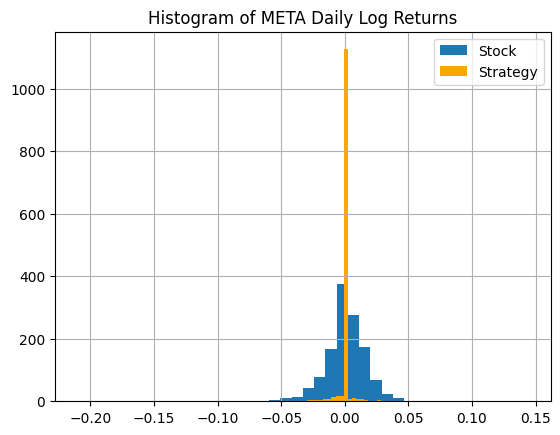

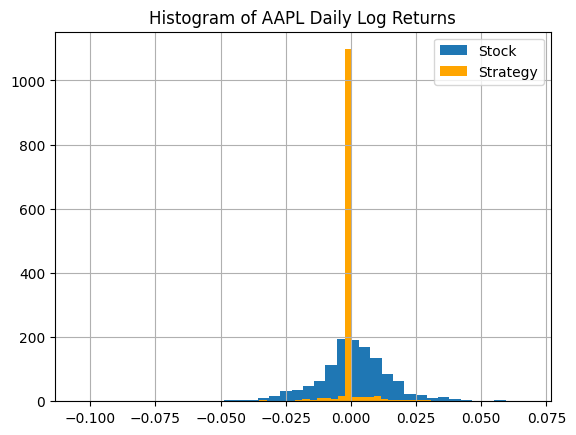

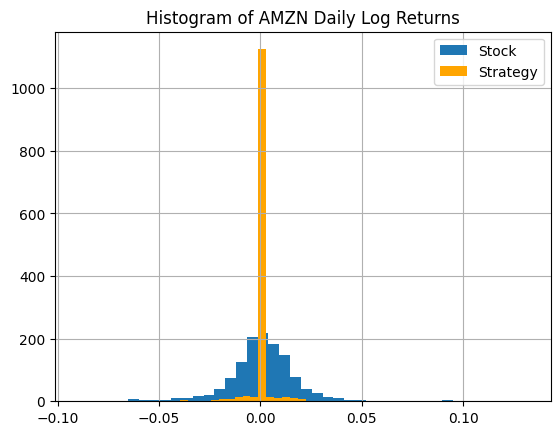

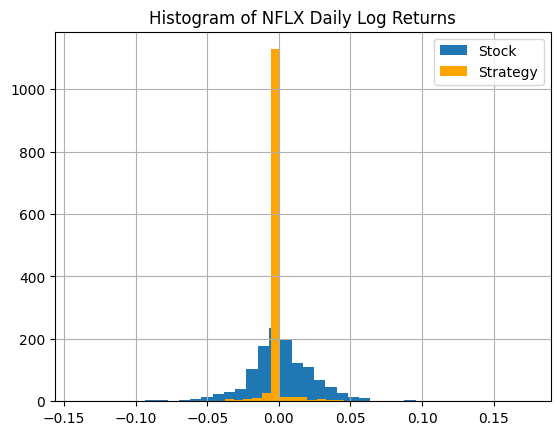

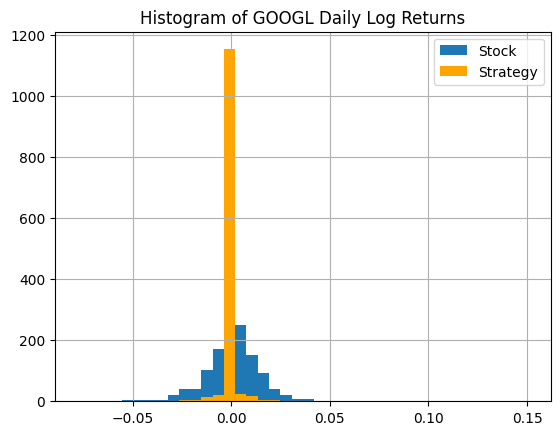

In [ ]:
# Create a 3x2 grid of subplots
for stock_name, df in stock_name_and_df_MACD_BB:
  plt.hist(df["Stock Log Returns"], bins = 40)
  plt.hist(df["Strategy Log Returns"], bins = 40, color = "Orange")
  plt.title(f"Histogram of {stock_name} Daily Log Returns")
  plt.legend(['Stock', 'Strategy'])
  plt.grid()
  plt.show()

In [ ]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

To convert log returns to regular returns:
Regular returns  = Exp(Log returns) - 1
Log Returns  = Ln(1 + Regular returns)

'''
benchmark_symbol = "^GSPC"
for stock_name, df in stock_name_and_df_MACD_BB:
  # 1.  Annual Mean Returns or Expected returns
  daily_ret = df[["Stock Log Returns", "Strategy Log Returns"]].mean()
  annual_ret =  daily_ret * 252
  #print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

  # Convert back to regular returns
  # Due to the statistical challenges, we cannot perform calculations on gross returns,
  # Hence, we do that in log returns, and then convert back to regular

  annual_regular_ret = np.exp(annual_ret)-1
  print(f'Annual {stock_name} regular returns are: \n',annual_regular_ret)

  #2. Annual Standard deviation
  daily_std = df[["Stock Log Returns", "Strategy Log Returns"]].std()
  annual_std =  daily_std * (252 **0.5)
  print(f'Annual log std is: \n', annual_std) # Note that these are the log returns

  #Convert to regular
  daily_regular_std = (np.exp(df[["Stock Log Returns", "Strategy Log Returns"]])-1).std()
  annual_regular_std =  daily_regular_std * (252 **0.5)
  print(f'Annual regular {stock_name} standard deviation is: \n', annual_regular_std) # Note that these are the log returns

  #3. Sharpe Ratio
  # Since we have already calculated the annual returns and risk we can use them

  sr = annual_regular_ret/ annual_regular_std
  print(f" The {stock_name} Sharpe Ratio is : \n ", sr, "\n\n")

Annual META regular returns are: 
 Stock Log Returns       0.211844
Strategy Log Returns   -0.041910
dtype: float64
Annual log std is: 
 Stock Log Returns       0.283982
Strategy Log Returns    0.095440
dtype: float64
Annual regular META standard deviation is: 
 Stock Log Returns       0.282297
Strategy Log Returns    0.095217
dtype: float64
 The META Sharpe Ratio is : 
  Stock Log Returns       0.750429
Strategy Log Returns   -0.440153
dtype: float64 


Annual AAPL regular returns are: 
 Stock Log Returns       0.238325
Strategy Log Returns    0.014707
dtype: float64
Annual log std is: 
 Stock Log Returns       0.248860
Strategy Log Returns    0.097506
dtype: float64
Annual regular AAPL standard deviation is: 
 Stock Log Returns       0.248457
Strategy Log Returns    0.097098
dtype: float64
 The AAPL Sharpe Ratio is : 
  Stock Log Returns       0.959222
Strategy Log Returns    0.151467
dtype: float64 


Annual AMZN regular returns are: 
 Stock Log Returns       0.431946
Strategy Log R

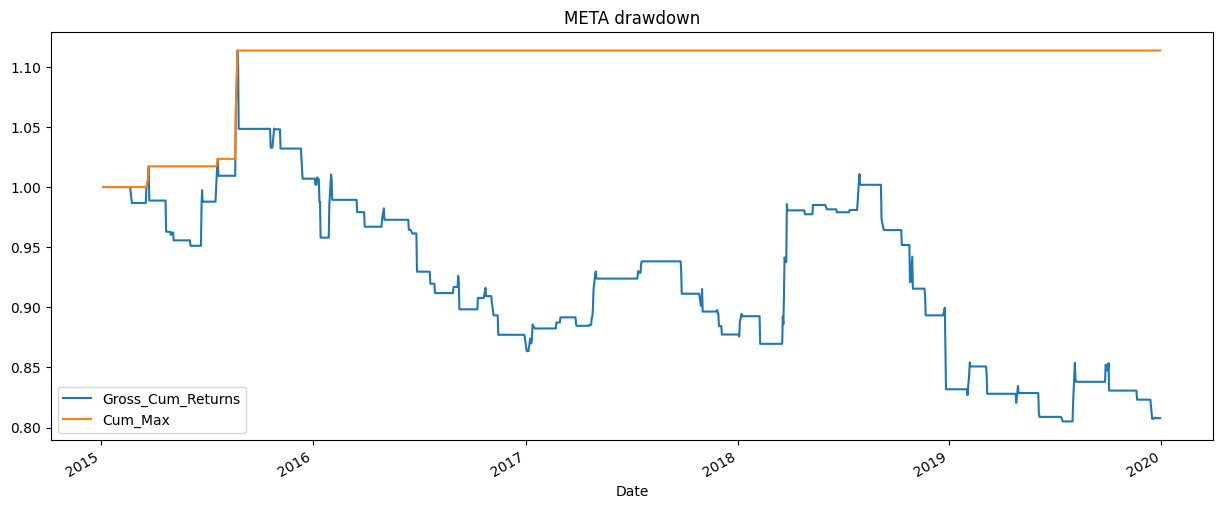

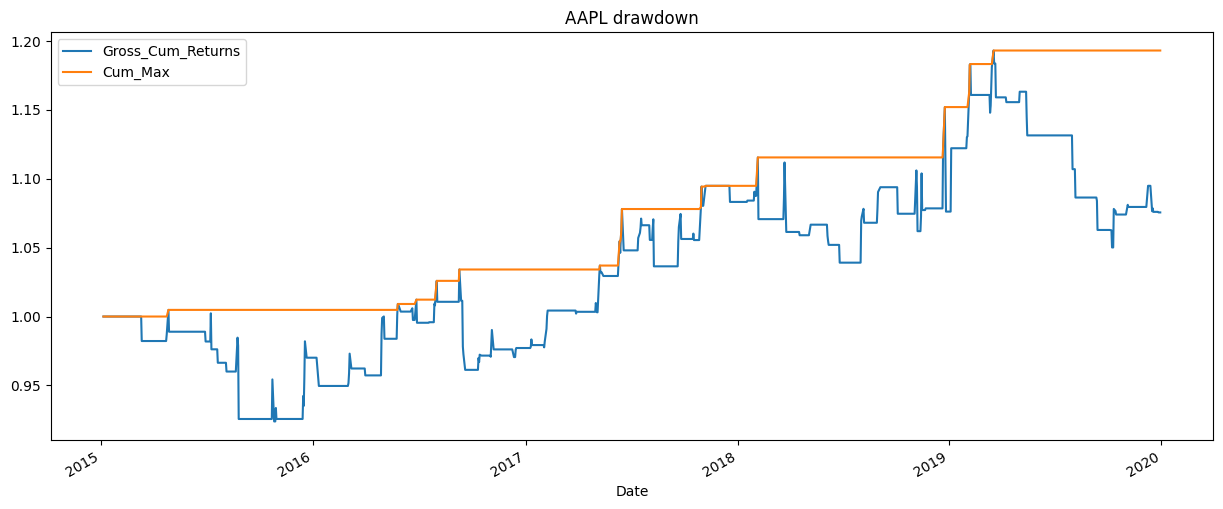

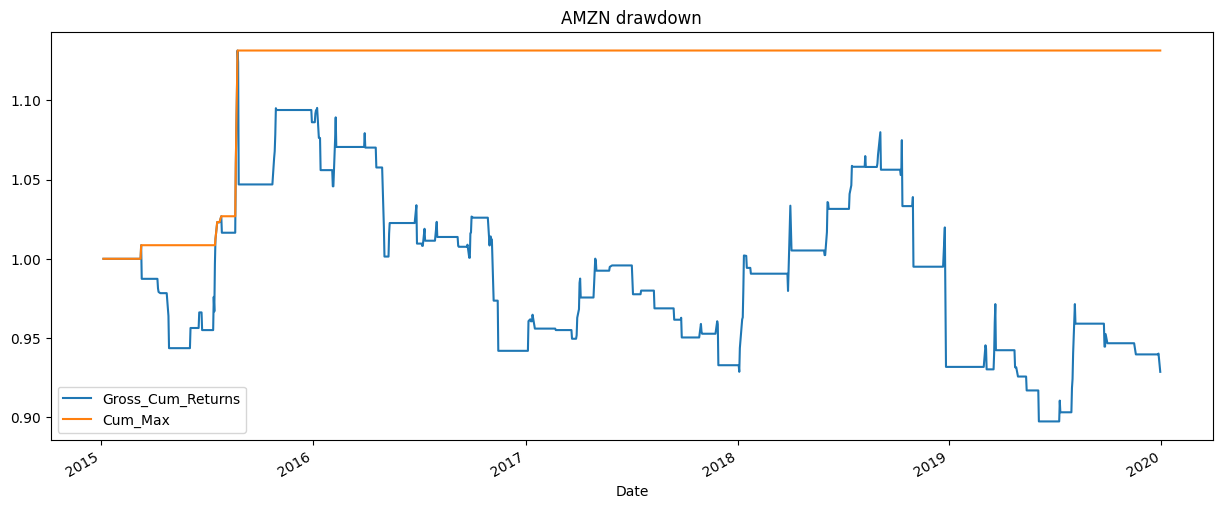

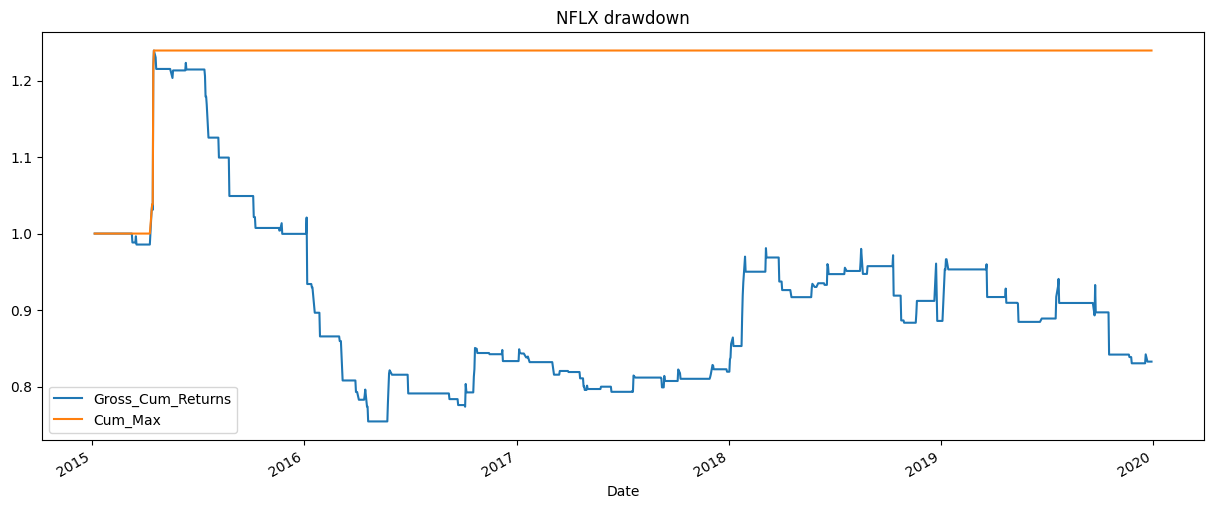

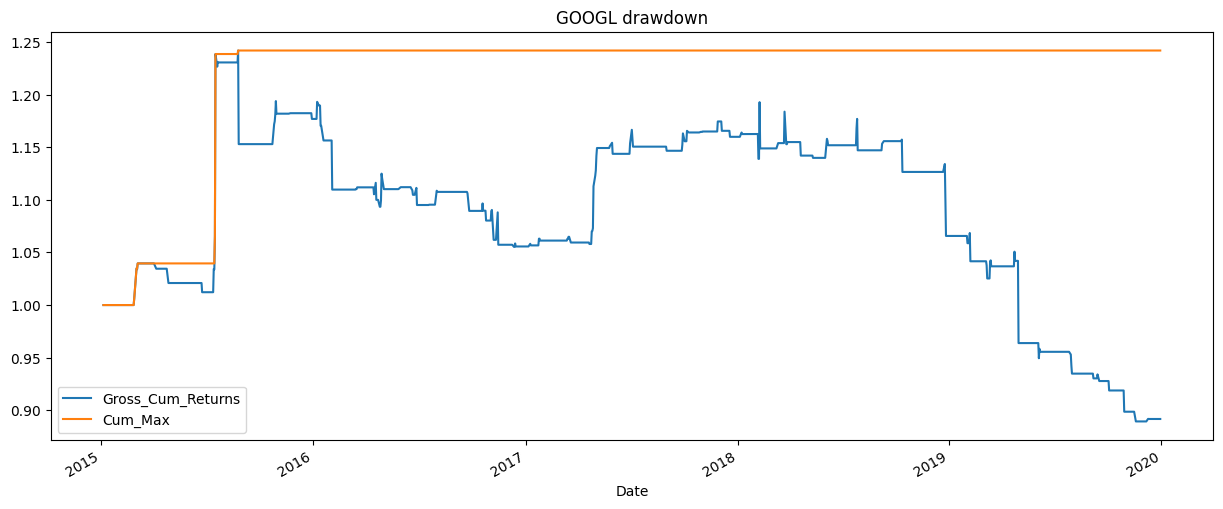

In [ ]:
for stock_name, df in stock_name_and_df_MACD_BB:
  df["Gross_Cum_Returns"] = df["Strategy Log Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
  df["Cum_Max"] = df["Gross_Cum_Returns"].cummax()
  df[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6), title = f"{stock_name} drawdown")

  drawdown = df["Cum_Max"] - df["Gross_Cum_Returns"] # it gives the difference between orange and blue

  df["drawdown"] = drawdown

  # The maximum difference is refered as "Drawdown"

  max_drawdown = df["drawdown"].max()


  # Although we know the max drawdown, we dont know how long it happened.
  # Lets calculate tha max drawdown period
  # The idea is to store all the points where the blue and orange meet (i.e. gross vs maximum)
  # and then calculate the difference between these points. The highest difference is the longest drawdown period.

  zero_periods = drawdown[drawdown == 0]

  zero_periods

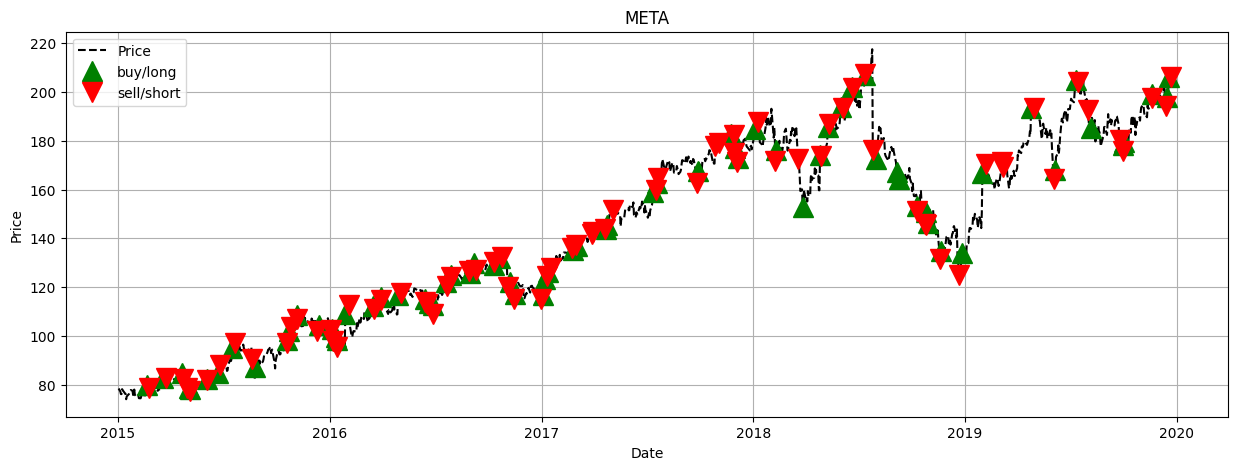

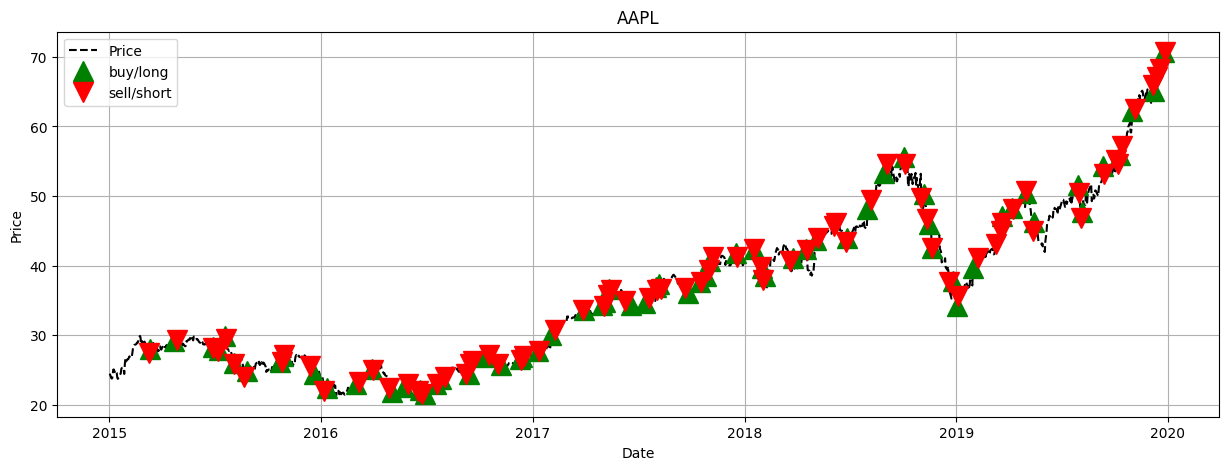

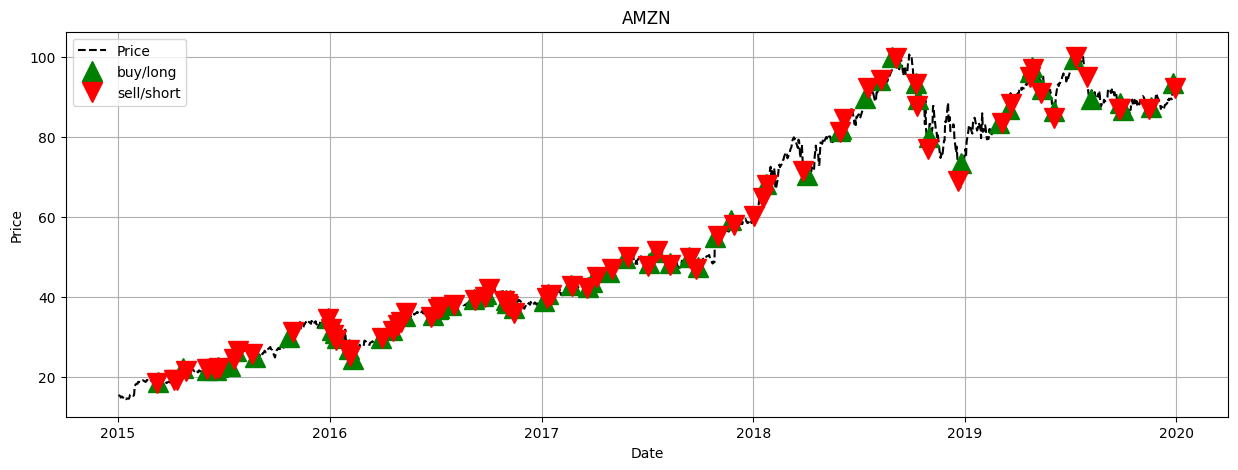

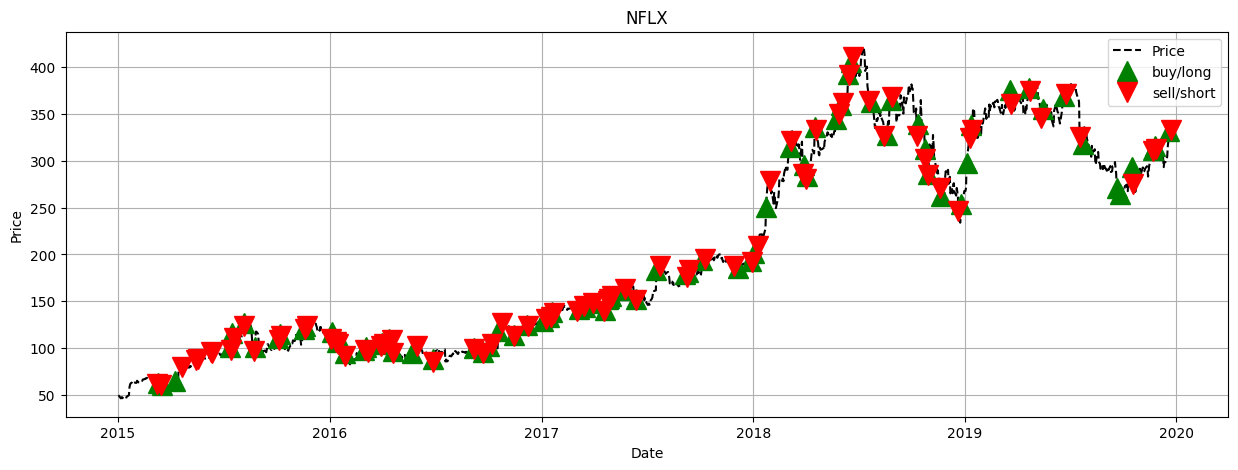

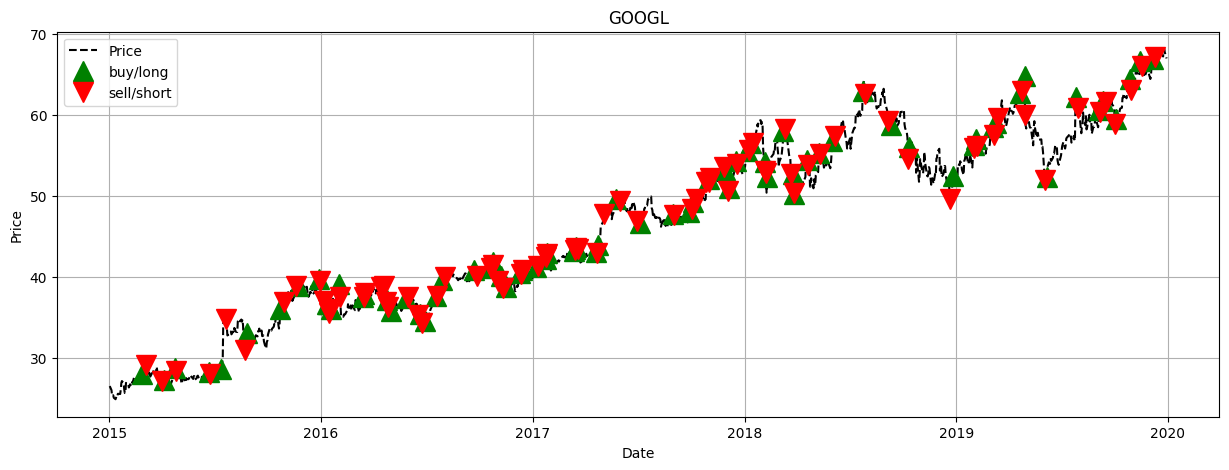

In [ ]:
# Price and signal plot
for stock_name, df in stock_name_and_df_MACD_BB:
    plt.figure(figsize=(15, 5))
    plt.plot(df["Close"] ,color='black', label='Price', linestyle='dashed')
    plt.plot(df[df['Signal'] == 1].index,  # plot ‘BUY crossover ’ signals
            df['Close'][df['Signal'] == 1],
            '^', markersize = 15, color = 'g', label = 'buy/long')
    plt.plot(df[df['Signal'] == -1].index,  # plot ‘SELL crossover ’ signals
            df['Close'][df['Signal'] == -1],
            'v', markersize = 15, color = 'r', label = 'sell/short')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("{}".format(stock_name))
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
#Computing the portfolio returns for each one of the strategies
#first: convert returns to daily log returns
daily_MACD_BB_returns = MACD_BB_portfolio_returns.apply(np.log1p).mean()
daily_MACD_portfolio_returns = MACD_portfolio_returns.apply(np.log1p).mean()
daily_MACD_RSI_portfolio_returns = MACD_RSI_portfolio_returns.apply(np.log1p).mean()

daily_MACD_RSI_sell_portfolio_returns = MACD_RSI_sell_portfolio_returns.apply(np.log1p).mean()
daily_MACD_RSI_buy_portfolio_returns = MACD_RSI_buy_portfolio_returns.apply(np.log1p).mean()

#annualise the log returns
annual_MACD_BB_portfolio_returns = daily_MACD_BB_returns * 252
annual_MACD_portfolio_returns = daily_MACD_portfolio_returns * 252
annual_MACD_RSI_portfolio_returns = daily_MACD_RSI_portfolio_returns * 252

annual_MACD_RSI_sell_portfolio_returns = daily_MACD_RSI_sell_portfolio_returns * 252
annual_MACD_RSI_buy_portfolio_returns = daily_MACD_RSI_buy_portfolio_returns * 252

#need to convert annual log returns to annual regular returns for the portfolios of each strategy
annual_regular_MACD_returns = np.exp(annual_MACD_portfolio_returns)-1
annual_regular_MACD_RSI_returns = np.exp(annual_MACD_RSI_portfolio_returns)-1
annual_regular_MACD_RSI_sell_returns = np.exp(annual_MACD_RSI_sell_portfolio_returns)-1
annual_regular_MACD_RSI_buy_returns = np.exp(annual_MACD_RSI_buy_portfolio_returns)-1
annual_regular_MACD_BB_returns = np.exp(annual_MACD_BB_portfolio_returns)-1

print(f"Annual MACD return: {annual_regular_MACD_returns}\n Annual MACD+RSI return: {annual_regular_MACD_RSI_returns} \n Annual MACD+BB return: {annual_regular_MACD_BB_returns}")
print(f"Annual MACD+RSI (Sell) return: {annual_regular_MACD_RSI_sell_returns}\n Annual MACD+RSI (Buy) return: {annual_regular_MACD_RSI_buy_returns}\n")

#calculate std deviation
annual_MACD_SD = MACD_portfolio_returns.std() * (252 ** 0.5)
annual_MACD_RSI_SD = MACD_RSI_portfolio_returns.std() * (252 ** 0.5)
annual_MACD_BB_SD = MACD_BB_portfolio_returns.std() * (252 ** 0.5)
annual_MACD_RSI_buy_SD = MACD_RSI_buy_portfolio_returns.std() * (252 ** 0.5)
annual_MACD_RSI_sell_SD = MACD_RSI_sell_portfolio_returns.std() * (252 ** 0.5)
print(f"Annual MACD standard deviation : {annual_MACD_SD}\n Annual MACD+RSI standard deviation: {annual_MACD_RSI_SD}\n Annual MACD+BB standard deviation: {annual_MACD_BB_SD}")
print(f"Annual MACD+RSI (Sell) standard deviation : {annual_MACD_RSI_sell_SD}\n Annual MACD+RSI (Buy) standard deviation: {annual_MACD_RSI_buy_SD}\n")

#calculate sharpe ratio
MACD_sr = annual_regular_MACD_returns/ annual_MACD_SD
MACD_RSI_sr = annual_regular_MACD_RSI_returns/annual_MACD_RSI_SD
MACD_RSI_buy_sr = annual_regular_MACD_RSI_buy_returns/annual_MACD_RSI_buy_SD
MACD_RSI_sell_sr = annual_regular_MACD_RSI_sell_returns/annual_MACD_RSI_sell_SD
MACD_BB_sr = annual_regular_MACD_BB_returns/annual_MACD_BB_SD
print(f"MACD sharpe ratio: {MACD_sr} \n MACD+RSI sharpe ratio: {MACD_RSI_sr}\n MACD+BB sharpe ratio: {MACD_BB_sr}")
print(f"MACD+RSI (Sell) sharpe ratio: {MACD_RSI_sell_sr} \n MACD+RSI (Buy) sharpe ratio: {MACD_RSI_buy_sr}")

Annual MACD return: -0.07463766773110059
 Annual MACD+RSI return: 0.020921288183303854 
 Annual MACD+BB return: -0.023005162660620138
Annual MACD+RSI (Sell) return: 0.13433007615706738
 Annual MACD+RSI (Buy) return: -0.1533595602423119

Annual MACD standard deviation : 0.18818948856021378
 Annual MACD+RSI standard deviation: 0.02868279753441034
 Annual MACD+BB standard deviation: 0.07021165911352154
Annual MACD+RSI (Sell) standard deviation : 0.1605573782162038
 Annual MACD+RSI (Buy) standard deviation: 0.16119249136202263

MACD sharpe ratio: -0.39660912148777777 
 MACD+RSI sharpe ratio: 0.7294019405954
 MACD+BB sharpe ratio: -0.3276544515694224
MACD+RSI (Sell) sharpe ratio: 0.8366484159711478 
 MACD+RSI (Buy) sharpe ratio: -0.9514063524080738


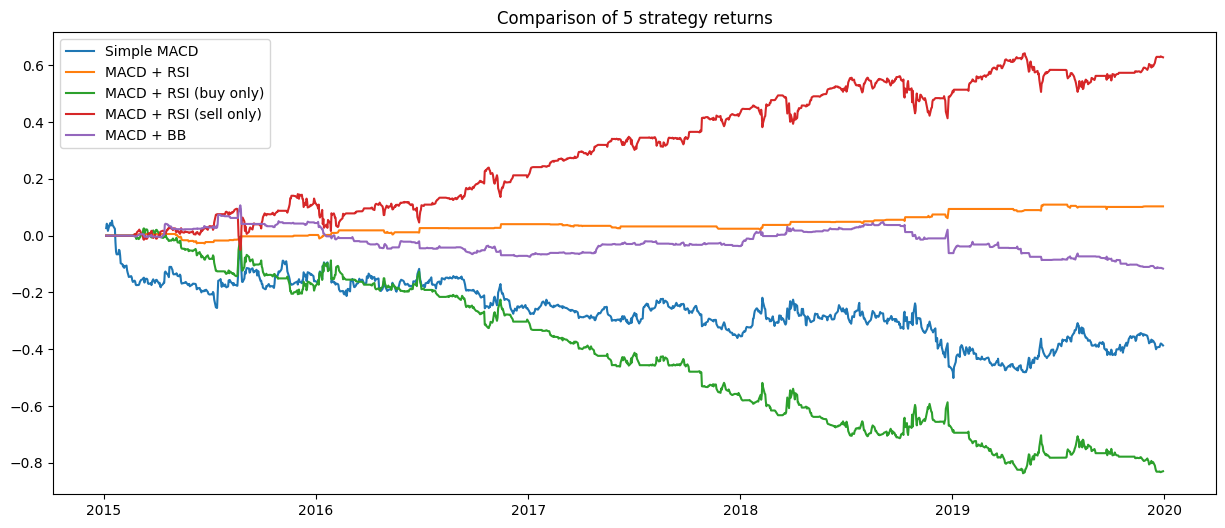

In [ ]:
# Plotting a comparision of portfolio returns for each of the strategies

MACD_returns = MACD_portfolio_returns.apply(np.log1p).cumsum()
MACD_RSI_returns = MACD_RSI_portfolio_returns.apply(np.log1p).cumsum()
MACD_RSI_buy_returns = MACD_RSI_buy_portfolio_returns.apply(np.log1p).cumsum()
MACD_RSI_sell_returns = MACD_RSI_sell_portfolio_returns.apply(np.log1p).cumsum()
MACD_BB_returns = MACD_BB_portfolio_returns.apply(np.log1p).cumsum()
plt.figure(figsize = (15,6))
plt.plot(MACD_returns, label = "Simple MACD")
plt.plot(MACD_RSI_returns, label = "MACD + RSI")
plt.plot(MACD_RSI_buy_returns, label = "MACD + RSI (buy only)")
plt.plot(MACD_RSI_sell_returns, label = "MACD + RSI (sell only)")
plt.plot(MACD_BB_returns, label = "MACD + BB")
plt.title("Comparison of 5 strategy returns")
plt.legend()
plt.show()
# .plot(figsize=(15,6), title = f"Portfolio Returns (Ichimoku + MFI)")

In [ ]:
MACD_BB_portfolio_returns.apply(np.log1p).cumsum()

Date
2015-01-02 00:00:00-05:00         NaN
2015-01-05 00:00:00-05:00    0.000000
2015-01-06 00:00:00-05:00    0.000000
2015-01-07 00:00:00-05:00    0.000000
2015-01-08 00:00:00-05:00    0.000000
                               ...   
2019-12-23 00:00:00-05:00   -0.113581
2019-12-24 00:00:00-05:00   -0.113581
2019-12-26 00:00:00-05:00   -0.113581
2019-12-27 00:00:00-05:00   -0.113547
2019-12-30 00:00:00-05:00   -0.116000
Name: Strategy Returns, Length: 1257, dtype: float64